# Оптимизация производственных расходов металлургического комбината

## Бизнес задача

Чтобы оптимизировать производственные расходы, металлургический комбинат ООО «Так закаляем сталь» решил уменьшить потребление электроэнергии на этапе обработки стали. Вам предстоит построить модель, которая предскажет температуру стали. Требование бизнеса: MAE ≤ 6.8.

## Описание этапа обработки стали

Сталь обрабатывают в металлическом ковше вместимостью около 100 тонн. Чтобы ковш выдерживал высокие температуры, изнутри его облицовывают огнеупорным кирпичом. Расплавленную сталь заливают в ковш и подогревают до нужной температуры графитовыми электродами. Они установлены в крышке ковша. 

Из сплава выводится сера (десульфурация), добавлением примесей корректируется химический состав и отбираются пробы. Сталь легируют — изменяют её состав — подавая куски сплава из бункера для сыпучих материалов или проволоку через специальный трайб-аппарат (англ. tribe, «масса»).

Перед тем как первый раз ввести легирующие добавки, измеряют температуру стали и производят её химический анализ. Потом температуру на несколько минут повышают, добавляют легирующие материалы и продувают сплав инертным газом. Затем его перемешивают и снова проводят измерения. Такой цикл повторяется до достижения целевого химического состава и оптимальной температуры плавки.

Тогда расплавленная сталь отправляется на доводку металла или поступает в машину непрерывной разливки. Оттуда готовый продукт выходит в виде заготовок-слябов (англ. *slab*, «плита»).

## Описание данных

Данные состоят из файлов, полученных из разных источников:

- `data_arc.csv` — данные об электродах;
- `data_bulk.csv` — данные о подаче сыпучих материалов (объём);
- `data_bulk_time.csv` — данные о подаче сыпучих материалов (время);
- `data_gas.csv` — данные о продувке сплава газом;
- `data_temp.csv` — результаты измерения температуры;
- `data_wire.csv` — данные о проволочных материалах (объём);
- `data_wire_time.csv` — данные о проволочных материалах (время).

Во всех файлах столбец `key` содержит номер партии. В файлах может быть несколько строк с одинаковым значением `key`: они соответствуют разным итерациям обработки.


## Исследовательский анализ данных

#### Загрузка библиотек, данных и их предварительный анализ

In [ ]:
!pip install catboost

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
!pip install xgboost

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import pandas as pd
import numpy as np
import warnings
warnings.simplefilter("ignore")
import matplotlib.pyplot as plt 
import seaborn as sns

from sklearn.ensemble import IsolationForest
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import StandardScaler

from sklearn.linear_model import LinearRegression
from catboost import CatBoostRegressor
from sklearn.ensemble import RandomForestRegressor
from xgboost.sklearn import XGBRegressor


In [ ]:
try:
    # просмотр, где находится каталог с файлами на COLAB
    from google.colab import drive
    drive.mount('/content/drive')
    # получение доступа к каталогу и уточнение названия папок
    import os
    os.listdir('/content/drive/My Drive/Colab Notebooks/Яндекс/ФИНАЛЬНЫЙ проект/final_steel.zip (Unzipped Files)/final_steel')
    # загрузка данных csv
    data_gas = pd.read_csv('/content/drive/My Drive/Colab Notebooks/Яндекс/ФИНАЛЬНЫЙ проект/final_steel.zip (Unzipped Files)/final_steel/data_gas.csv')
    data_wire = pd.read_csv('/content/drive/My Drive/Colab Notebooks/Яндекс/ФИНАЛЬНЫЙ проект/final_steel.zip (Unzipped Files)/final_steel/data_wire.csv')
    data_temp = pd.read_csv('/content/drive/My Drive/Colab Notebooks/Яндекс/ФИНАЛЬНЫЙ проект/final_steel.zip (Unzipped Files)/final_steel/data_temp.csv')
    data_arc = pd.read_csv('/content/drive/My Drive/Colab Notebooks/Яндекс/ФИНАЛЬНЫЙ проект/final_steel.zip (Unzipped Files)/final_steel/data_arc.csv')
    data_bulk = pd.read_csv('/content/drive/My Drive/Colab Notebooks/Яндекс/ФИНАЛЬНЫЙ проект/final_steel.zip (Unzipped Files)/final_steel/data_bulk.csv')
    data_wire_time = pd.read_csv('/content/drive/My Drive/Colab Notebooks/Яндекс/ФИНАЛЬНЫЙ проект/final_steel.zip (Unzipped Files)/final_steel/data_wire_time.csv')
    data_bulk_time = pd.read_csv('/content/drive/My Drive/Colab Notebooks/Яндекс/ФИНАЛЬНЫЙ проект/final_steel.zip (Unzipped Files)/final_steel/data_bulk_time.csv')
    
except ModuleNotFoundError:
    # загрузка данных csv
    data_gas = pd.read_csv('/datasets/final_steel/data_gas.csv')
    data_wire = pd.read_csv('/datasets/final_steel/data_wire.csv')
    data_temp = pd.read_csv('/datasets/final_steel/data_temp.csv')
    data_arc = pd.read_csv('/datasets/final_steel/data_arc.csv')
    data_bulk = pd.read_csv('/datasets/final_steel/data_bulk.csv')
    data_wire_time = pd.read_csv('/datasets/final_steel/data_wire_time.csv')
    data_bulk_time = pd.read_csv('/datasets/final_steel/data_bulk_time.csv')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
list_data = [data_gas,
             data_wire,
             data_temp,
             data_arc,
             data_bulk,
             data_wire_time,
             data_bulk_time]

In [ ]:
list_name_data = ['ДАННЫЕ О ПРОДУВКЕ СПЛАВА ГАЗОМ',
             'ДАННЫЕ О ПРОВОЛОЧНЫХ МАТЕРИАЛАХ (ОБЪЁМ)',
             'РЕЗУЛЬТАТЫ ИЗМЕРЕНИЯ ТЕМПЕРАТУРЫ',
             'ДАННЫЕ ОБ ЭЛЕКТРОДАХ',
             'ДАННЫЕ О ПОДАЧЕ СЫПУЧИХ МАТЕРИАЛОВ (ОБЪЁМ)',
             'ДАННЫЕ О ПРОВОЛОЧНЫХ МАТЕРИАЛАХ (ВРЕМЯ)',
             'ДАННЫЕ О ПОДАЧЕ СЫПУЧИХ МАТЕРИАЛОВ (ВРЕМЯ)']

In [ ]:
i_name = 0
for dat in list_data:
  print(list_name_data[i_name])
  print(dat.head())
  #display(dat.head())
  i_name = i_name + 1
  print('###########################################################################')

ДАННЫЕ О ПРОДУВКЕ СПЛАВА ГАЗОМ
   key      Газ 1
0    1  29.749986
1    2  12.555561
2    3  28.554793
3    4  18.841219
4    5   5.413692
###########################################################################
ДАННЫЕ О ПРОВОЛОЧНЫХ МАТЕРИАЛАХ (ОБЪЁМ)
   key     Wire 1   Wire 2  Wire 3  Wire 4  Wire 5  Wire 6  Wire 7  Wire 8  \
0    1  60.059998      NaN     NaN     NaN     NaN     NaN     NaN     NaN   
1    2  96.052315      NaN     NaN     NaN     NaN     NaN     NaN     NaN   
2    3  91.160157      NaN     NaN     NaN     NaN     NaN     NaN     NaN   
3    4  89.063515      NaN     NaN     NaN     NaN     NaN     NaN     NaN   
4    5  89.238236  9.11456     NaN     NaN     NaN     NaN     NaN     NaN   

   Wire 9  
0     NaN  
1     NaN  
2     NaN  
3     NaN  
4     NaN  
###########################################################################
РЕЗУЛЬТАТЫ ИЗМЕРЕНИЯ ТЕМПЕРАТУРЫ
   key         Время замера  Температура
0    1  2019-05-03 11:16:18       1571.0
1    1  2019-

In [ ]:
print('                                                      --/ ОБЩАЯ ИНФОРМАЦИЯ, ПРОВЕРКА ТИПОВ /--')
i_name = 0
for dat in list_data:
  print(list_name_data[i_name])
  dat.info()
  i_name = i_name + 1
  print('##########################################')


                                                      --/ ОБЩАЯ ИНФОРМАЦИЯ, ПРОВЕРКА ТИПОВ /--
ДАННЫЕ О ПРОДУВКЕ СПЛАВА ГАЗОМ
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3239 entries, 0 to 3238
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   key     3239 non-null   int64  
 1   Газ 1   3239 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 50.7 KB
##########################################
ДАННЫЕ О ПРОВОЛОЧНЫХ МАТЕРИАЛАХ (ОБЪЁМ)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   key     3081 non-null   int64  
 1   Wire 1  3055 non-null   float64
 2   Wire 2  1079 non-null   float64
 3   Wire 3  63 non-null     float64
 4   Wire 4  14 non-null     float64
 5   Wire 5  1 non-null      float64
 6   Wire 6  73 non-null     float64
 7   Wire 7  11 non-null     float64
 8   Wire

### Вывод

**В результате предварительного анализа данных, установлено:**

1. В столбце "Время замера" таблицы `data_temp` (результаты измерения температуры) тип object, а должен быть datetime.
2. В столбце "Начало нагрева дугой" таблицы `data_arc` (данные об электродах) тип object, а должен быть datetime.
3. В столбце "Конец нагрева дугой" таблицы `data_arc` (данные об электродах) тип object, а должен быть datetime.
4. Во всех столбцах таблиц `data_wire_time` (данные о проволочных материалах (время)), `data_bulk_time` (данные о подаче сыпучих материалов (время)) тип object, а должен быть datetime.


In [ ]:
print('                                                        --/ ОПИСАТЕЛЬНАЯ СТАТИСТИКА /--')
i_name = 0
for dat in list_data:
  print(list_name_data[i_name])
  display(dat.describe())
  i_name = i_name + 1
  print('#####################################################################################################################')


                                                        --/ ОПИСАТЕЛЬНАЯ СТАТИСТИКА /--
ДАННЫЕ О ПРОДУВКЕ СПЛАВА ГАЗОМ


,key,Газ 1
count,3239.000000,3239.000000
mean,1621.861377,11.002062
std,935.386334,6.220327
min,1.000000,0.008399
25%,812.500000,7.043089
50%,1622.000000,9.836267
75%,2431.500000,13.769915
max,3241.000000,77.995040


#####################################################################################################################
ДАННЫЕ О ПРОВОЛОЧНЫХ МАТЕРИАЛАХ (ОБЪЁМ)


,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
count,3081.000000,3055.000000,1079.000000,63.000000,14.000000,1.000,73.000000,11.000000,19.000000,29.000000
mean,1623.426485,100.895853,50.577323,189.482681,57.442841,15.132,48.016974,10.039007,53.625193,34.155752
std,932.996726,42.012518,39.320216,99.513444,28.824667,NaN,33.919845,8.610584,16.881728,19.931616
min,1.000000,1.918800,0.030160,0.144144,24.148801,15.132,0.034320,0.234208,45.076721,4.622800
25%,823.000000,72.115684,20.193680,95.135044,40.807002,15.132,25.053600,6.762756,46.094879,22.058401
50%,1619.000000,100.158234,40.142956,235.194977,45.234282,15.132,42.076324,9.017009,46.279999,30.066399
75%,2434.000000,126.060483,70.227558,276.252014,76.124619,15.132,64.212723,11.886057,48.089603,43.862003
max,3241.000000,330.314424,282.780152,385.008668,113.231044,15.132,180.454575,32.847674,102.762401,90.053604


#####################################################################################################################
РЕЗУЛЬТАТЫ ИЗМЕРЕНИЯ ТЕМПЕРАТУРЫ


,key,Температура
count,15907.000000,13006.000000
mean,1607.880870,1591.840920
std,942.212073,21.375851
min,1.000000,1191.000000
25%,790.000000,1581.000000
50%,1618.000000,1591.000000
75%,2427.000000,1601.000000
max,3241.000000,1705.000000


#####################################################################################################################
ДАННЫЕ ОБ ЭЛЕКТРОДАХ


,key,Активная мощность,Реактивная мощность
count,14876.000000,14876.000000,14876.000000
mean,1615.220422,0.670441,0.452592
std,934.571502,0.408159,5.878702
min,1.000000,0.030002,-715.504924
25%,806.000000,0.395297,0.290991
50%,1617.000000,0.555517,0.415962
75%,2429.000000,0.857034,0.637371
max,3241.000000,3.731596,2.676388


#####################################################################################################################
ДАННЫЕ О ПОДАЧЕ СЫПУЧИХ МАТЕРИАЛОВ (ОБЪЁМ)


,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
count,3129.000000,252.000000,22.000000,1298.000000,1014.000000,77.000000,576.000000,25.000000,1.0,19.000000,176.000000,177.000000,2450.000000,18.000000,2806.000000,2248.000000
mean,1624.383509,39.242063,253.045455,113.879045,104.394477,107.025974,118.925347,305.600000,49.0,76.315789,83.284091,76.819209,260.471020,181.111111,170.284747,160.513345
std,933.337642,18.277654,21.180578,75.483494,48.184126,81.790646,72.057776,191.022904,NaN,21.720581,26.060347,59.655365,120.649269,46.088009,65.868652,51.765319
min,1.000000,10.000000,228.000000,6.000000,12.000000,11.000000,17.000000,47.000000,49.0,63.000000,24.000000,8.000000,53.000000,151.000000,16.000000,1.000000
25%,816.000000,27.000000,242.000000,58.000000,72.000000,70.000000,69.750000,155.000000,49.0,66.000000,64.000000,25.000000,204.000000,153.250000,119.000000,105.000000
50%,1622.000000,31.000000,251.500000,97.500000,102.000000,86.000000,100.000000,298.000000,49.0,68.000000,86.500000,64.000000,208.000000,155.500000,151.000000,160.000000
75%,2431.000000,46.000000,257.750000,152.000000,133.000000,132.000000,157.000000,406.000000,49.0,70.500000,102.000000,106.000000,316.000000,203.500000,205.750000,205.000000
max,3241.000000,185.000000,325.000000,454.000000,281.000000,603.000000,503.000000,772.000000,49.0,147.000000,159.000000,313.000000,1849.000000,305.000000,636.000000,405.000000


#####################################################################################################################
ДАННЫЕ О ПРОВОЛОЧНЫХ МАТЕРИАЛАХ (ВРЕМЯ)


,key
count,3081.000000
mean,1623.426485
std,932.996726
min,1.000000
25%,823.000000
50%,1619.000000
75%,2434.000000
max,3241.000000


#####################################################################################################################
ДАННЫЕ О ПОДАЧЕ СЫПУЧИХ МАТЕРИАЛОВ (ВРЕМЯ)


,key
count,3129.000000
mean,1624.383509
std,933.337642
min,1.000000
25%,816.000000
50%,1622.000000
75%,2431.000000
max,3241.000000


#####################################################################################################################


### Вывод

**В результате анализа описательной статистики и пропусков, установлено:**

1. В таблице `data_wire` (данные о проволочных материалах (объём)) многие столбцы имеют пропуски от 0.84% до 99.97%.
2. В таблице `data_temp` (результаты измерения температуры) в столбце "Температура" имеется 18.24% пропусков.
3. В таблице `data_bulk` (данные о подаче сыпучих материалов (объём)) многие столбцы имеют пропуски от 10.32% до 99.97%.
4. В таблице `data_arc` (данные об электродах) в столбце "Реактивная мощность" обнаружено аномальное минимальное значение: - 715.504924.


In [ ]:
print('                                                           --/ ПРОЦЕНТ ПРОПУСКОВ, % /--')
i_name = 0
for dat in list_data:
  print(list_name_data[i_name])
  display(round((dat.isna().sum() / len(dat)) * 100, 2).sort_values())
  i_name = i_name + 1
  print('####################################')




                                                           --/ ПРОЦЕНТ ПРОПУСКОВ, % /--
ДАННЫЕ О ПРОДУВКЕ СПЛАВА ГАЗОМ


key      0.0
Газ 1    0.0
dtype: float64

####################################
ДАННЫЕ О ПРОВОЛОЧНЫХ МАТЕРИАЛАХ (ОБЪЁМ)


key        0.00
Wire 1     0.84
Wire 2    64.98
Wire 6    97.63
Wire 3    97.96
Wire 9    99.06
Wire 8    99.38
Wire 4    99.55
Wire 7    99.64
Wire 5    99.97
dtype: float64

####################################
РЕЗУЛЬТАТЫ ИЗМЕРЕНИЯ ТЕМПЕРАТУРЫ


key              0.00
Время замера     0.00
Температура     18.24
dtype: float64

####################################
ДАННЫЕ ОБ ЭЛЕКТРОДАХ


key                     0.0
Начало нагрева дугой    0.0
Конец нагрева дугой     0.0
Активная мощность       0.0
Реактивная мощность     0.0
dtype: float64

####################################
ДАННЫЕ О ПОДАЧЕ СЫПУЧИХ МАТЕРИАЛОВ (ОБЪЁМ)


key         0.00
Bulk 14    10.32
Bulk 12    21.70
Bulk 15    28.16
Bulk 3     58.52
Bulk 4     67.59
Bulk 6     81.59
Bulk 1     91.95
Bulk 11    94.34
Bulk 10    94.38
Bulk 5     97.54
Bulk 7     99.20
Bulk 2     99.30
Bulk 9     99.39
Bulk 13    99.42
Bulk 8     99.97
dtype: float64

####################################
ДАННЫЕ О ПРОВОЛОЧНЫХ МАТЕРИАЛАХ (ВРЕМЯ)


key        0.00
Wire 1     0.84
Wire 2    64.98
Wire 6    97.63
Wire 3    97.96
Wire 9    99.06
Wire 8    99.38
Wire 4    99.55
Wire 7    99.64
Wire 5    99.97
dtype: float64

####################################
ДАННЫЕ О ПОДАЧЕ СЫПУЧИХ МАТЕРИАЛОВ (ВРЕМЯ)


key         0.00
Bulk 14    10.32
Bulk 12    21.70
Bulk 15    28.16
Bulk 3     58.52
Bulk 4     67.59
Bulk 6     81.59
Bulk 1     91.95
Bulk 11    94.34
Bulk 10    94.38
Bulk 5     97.54
Bulk 7     99.20
Bulk 2     99.30
Bulk 9     99.39
Bulk 13    99.42
Bulk 8     99.97
dtype: float64

####################################


#### Графический анализ

**При графическом анализе будем исходить из следующих положений:**

1. Поскольку случайные величины всегда порождаются бесконечным количеством причин и чаще всего ни одна из них не имеет дисперсии, сравнимой с дисперсией самой случайной величины, то большинство встречающихся **в практике** случайных величин подчинено **нормальному закону распределения**. [Нормальное распределение — **наиболее распространенное в природе распределение** непрерывных величин. Математическим обоснованием этого факта служит центральная предельная теорема](http://datascientist.one/central-limit-theorem/).

2. **Выбросом** считается наблюдение, которое лежит аномально далеко от остальных из серии параллельных наблюдений. Т.е. выбросы – это значения количественного признака, располагающиеся на краях интервала допустимых значений. Таким образом, при определении выбросов будем опираться на значения 0-перцентиля и 100-перцентиля, а также рекомендации бизнеса и особенности технологического процесса. **Удалению будут подлежать супервыбросы (относительно далеко отстающие единичные значения или небольшие группы  относительно основного распределения).**

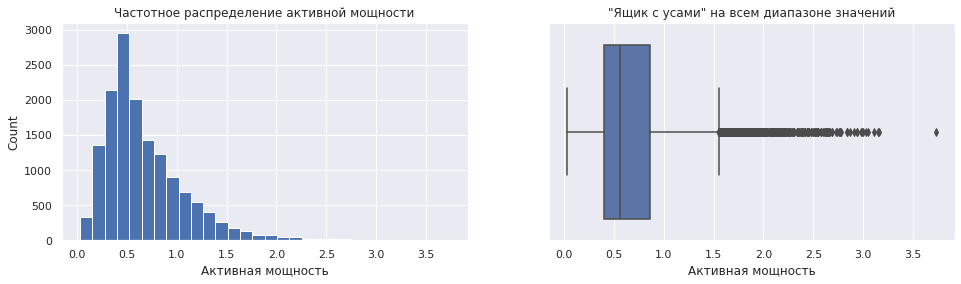

In [ ]:
sns.set(style="darkgrid")
plt.rcParams["figure.figsize"] = (16,4)

plt.subplot(1, 2, 1)
data_arc['Активная мощность'].plot(kind='hist', bins=30)
plt.title("Частотное распределение активной мощности", fontsize=12)
plt.xlabel("Активная мощность")
plt.ylabel("Count")

plt.subplot(1, 2, 2)
sns.boxplot(data=data_arc, x='Активная мощность')
plt.title('"Ящик с усами" на всем диапазоне значений', fontsize=12)
plt.xlabel("Активная мощность");

In [ ]:
round(np.percentile (data_arc['Активная мощность'].dropna(), 0), 2)

0.03

In [ ]:
round(np.percentile (data_arc['Активная мощность'].dropna(), 100), 2)

3.73

Исключим значение активной мощности большее 3.5, так как оно является явным супервыбросом. Таким образом, моделирование будем проводит в диапазоне [0, 3.5].

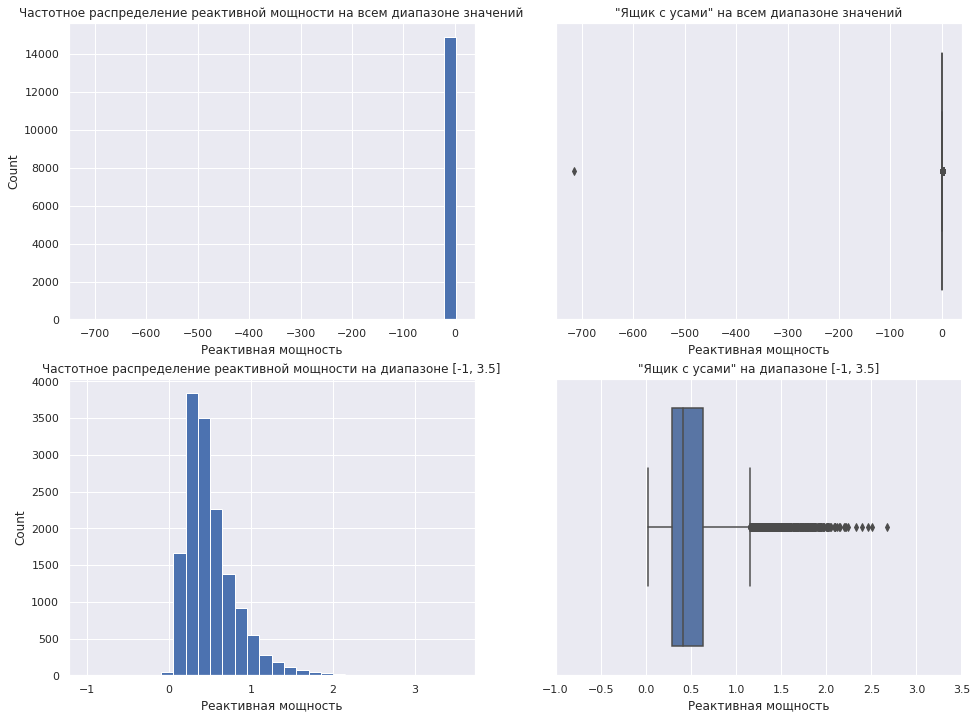

In [ ]:
sns.set(style="darkgrid")
plt.rcParams["figure.figsize"] = (16, 12)

plt.subplot(2, 2, 1)
data_arc['Реактивная мощность'].plot(kind='hist', bins=30)
plt.title("Частотное распределение реактивной мощности на всем диапазоне значений", fontsize=12)
plt.xlabel("Реактивная мощность")
plt.ylabel("Count")

plt.subplot(2, 2, 2)
sns.boxplot(data=data_arc, x='Реактивная мощность')
plt.title('"Ящик с усами" на всем диапазоне значений', fontsize=12)
plt.xlabel("Реактивная мощность")

plt.subplot(2, 2, 3)
data_arc['Реактивная мощность'].plot(kind='hist', bins=30, range = (-1, 3.5))
plt.title("Частотное распределение реактивной мощности на диапазоне [-1, 3.5]", fontsize=12)
plt.xlabel("Реактивная мощность")
plt.ylabel("Count")

plt.subplot(2, 2, 4)
sns.boxplot(data=data_arc, x='Реактивная мощность')
plt.title('"Ящик с усами" на диапазоне [-1, 3.5]', fontsize=12)
plt.xlabel("Реактивная мощность")
plt.xlim(-1, 3.5);

In [ ]:
round(np.percentile (data_arc['Реактивная мощность'].dropna(), 0), 2)

-715.5

In [ ]:
round(np.percentile (data_arc['Реактивная мощность'].dropna(), 100), 2)

2.68

С учетом рекомендаций бизнеса и технологического процесса, исключим значение реактивной мощности менее 0, так как оно является явно супервыбросом. Таким образом, моделирование будем проводит в диапазоне [0, 3.5].

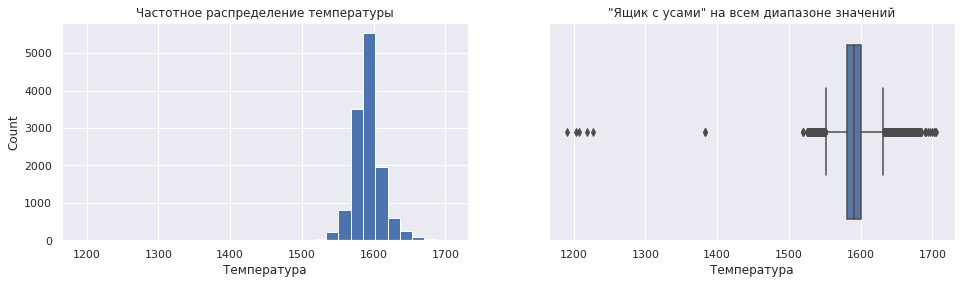

In [ ]:
sns.set(style="darkgrid")
plt.rcParams["figure.figsize"] = (16,4)

plt.subplot(1, 2, 1)
data_temp['Температура'].plot(kind='hist', bins=30)
plt.title("Частотное распределение температуры", fontsize=12)
plt.xlabel("Температура")
plt.ylabel("Count")

plt.subplot(1, 2, 2)
sns.boxplot(data=data_temp, x='Температура')
plt.title('"Ящик с усами" на всем диапазоне значений', fontsize=12)
plt.xlabel("Температура");

In [ ]:
round(np.percentile (data_temp['Температура'].dropna(), 0))

1191

In [ ]:
round(np.percentile (data_temp['Температура'].dropna(), 100))

1705

Исключим значение температуры менее 1400, так как оно является явным супервыбросом. Таким образом, моделирование будем проводит в диапазоне [1400, 1705].

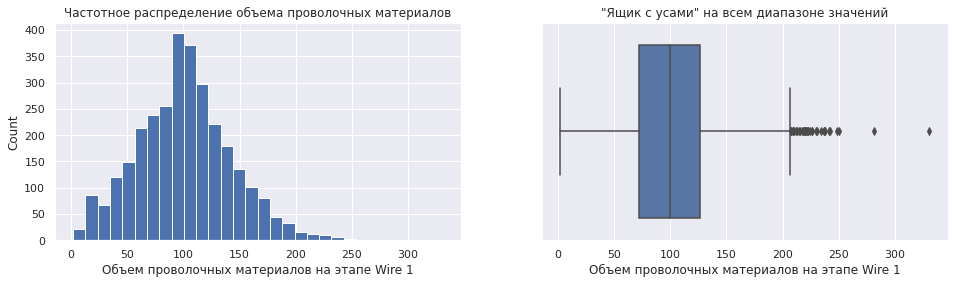

In [ ]:
sns.set(style="darkgrid")
plt.rcParams["figure.figsize"] = (16,4)

plt.subplot(1, 2, 1)
data_wire['Wire 1'].plot(kind='hist', bins=30)
plt.title("Частотное распределение объема проволочных материалов", fontsize=12)
plt.xlabel("Объем проволочных материалов на этапе Wire 1")
plt.ylabel("Count")

plt.subplot(1, 2, 2)
sns.boxplot(data=data_wire, x='Wire 1')
plt.title('"Ящик с усами" на всем диапазоне значений', fontsize=12)
plt.xlabel("Объем проволочных материалов на этапе Wire 1");

In [ ]:
round(np.percentile (data_wire['Wire 1'].dropna(), 0))

2

In [ ]:
round(np.percentile (data_wire['Wire 1'].dropna(), 100))

330

На этапе Wire 1 исключим значение объем проволочных материалов более 260, так как оно является явным супервыбросом. Таким образом, моделирование будем проводит в диапазоне [0, 260].

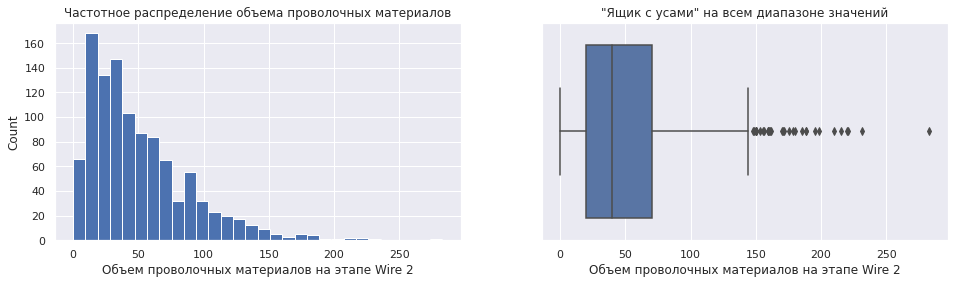

In [ ]:
sns.set(style="darkgrid")
plt.rcParams["figure.figsize"] = (16,4)

plt.subplot(1, 2, 1)
data_wire['Wire 2'].plot(kind='hist', bins=30)
plt.title("Частотное распределение объема проволочных материалов", fontsize=12)
plt.xlabel("Объем проволочных материалов на этапе Wire 2")
plt.ylabel("Count")

plt.subplot(1, 2, 2)
sns.boxplot(data=data_wire, x='Wire 2')
plt.title('"Ящик с усами" на всем диапазоне значений', fontsize=12)
plt.xlabel("Объем проволочных материалов на этапе Wire 2");

In [ ]:
round(np.percentile (data_wire['Wire 2'].dropna(), 0))

0

In [ ]:
round(np.percentile (data_wire['Wire 2'].dropna(), 100))

283

На этапе Wire 2 исключим значение объем проволочных материалов более 260, так как оно является явным супервыбросом. Таким образом, моделирование будем проводит в диапазоне [0, 260].

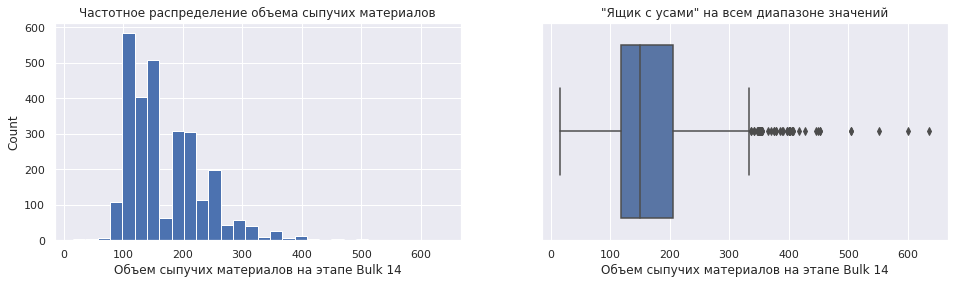

In [ ]:
sns.set(style="darkgrid")
plt.rcParams["figure.figsize"] = (16,4)

plt.subplot(1, 2, 1)
data_bulk['Bulk 14'].plot(kind='hist', bins=30)
plt.title("Частотное распределение объема сыпучих материалов", fontsize=12)
plt.xlabel("Объем сыпучих материалов на этапе Bulk 14")
plt.ylabel("Count")

plt.subplot(1, 2, 2)
sns.boxplot(data=data_bulk, x='Bulk 14')
plt.title('"Ящик с усами" на всем диапазоне значений', fontsize=12)
plt.xlabel("Объем сыпучих материалов на этапе Bulk 14");

In [ ]:
round(np.percentile (data_bulk['Bulk 14'].dropna(), 0))

16

In [ ]:
round(np.percentile (data_bulk['Bulk 14'].dropna(), 100))

636

С учетом рекомендаций бизнеса и технологического процесса, пока оставим как есть. Таким образом, моделирование будем проводит в диапазоне [0, 700].

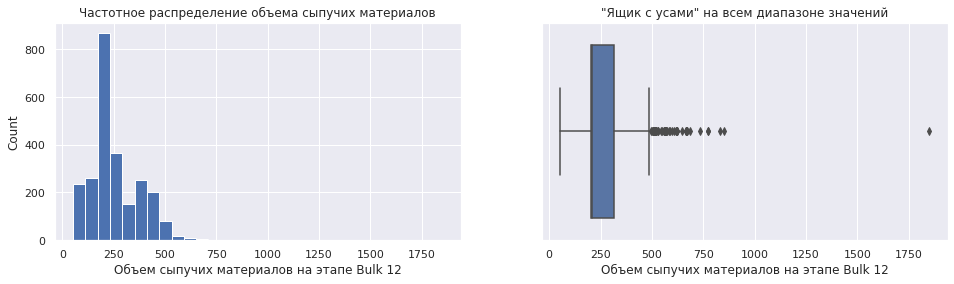

In [ ]:
sns.set(style="darkgrid")
plt.rcParams["figure.figsize"] = (16,4)

plt.subplot(1, 2, 1)
data_bulk['Bulk 12'].plot(kind='hist', bins=30)
plt.title("Частотное распределение объема сыпучих материалов", fontsize=12)
plt.xlabel("Объем сыпучих материалов на этапе Bulk 12")
plt.ylabel("Count")

plt.subplot(1, 2, 2)
sns.boxplot(data=data_bulk, x='Bulk 12')
plt.title('"Ящик с усами" на всем диапазоне значений', fontsize=12)
plt.xlabel("Объем сыпучих материалов на этапе Bulk 12");

In [ ]:
np.percentile (data_bulk['Bulk 12'].dropna(), 0)

53.0

In [ ]:
np.percentile (data_bulk['Bulk 12'].dropna(), 100)

1849.0

На этапе Bulk 12 исключим значение объем сыпучих материалов более 1000, так как оно является явным супервыбросом. Таким образом, моделирование будем проводит в диапазоне [0, 1000].

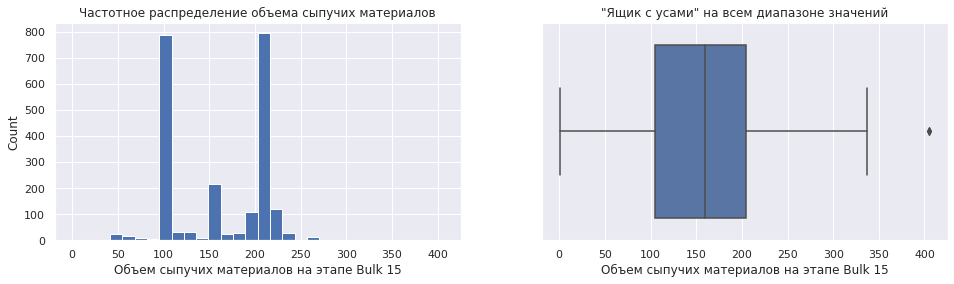

In [ ]:
sns.set(style="darkgrid")
plt.rcParams["figure.figsize"] = (16,4)

plt.subplot(1, 2, 1)
data_bulk['Bulk 15'].plot(kind='hist', bins=30)
plt.title("Частотное распределение объема сыпучих материалов", fontsize=12)
plt.xlabel("Объем сыпучих материалов на этапе Bulk 15")
plt.ylabel("Count")

plt.subplot(1, 2, 2)
sns.boxplot(data=data_bulk, x='Bulk 15')
plt.title('"Ящик с усами" на всем диапазоне значений', fontsize=12)
plt.xlabel("Объем сыпучих материалов на этапе Bulk 15");

In [ ]:
np.percentile (data_bulk['Bulk 15'].dropna(), 0)

1.0

In [ ]:
np.percentile (data_bulk['Bulk 15'].dropna(), 100)

405.0

На этапе Bulk 15 исключим значение объем сыпучих материалов более 400, так как оно является явным супервыбросом. Таким образом, моделирование будем проводит в диапазоне [0, 400].

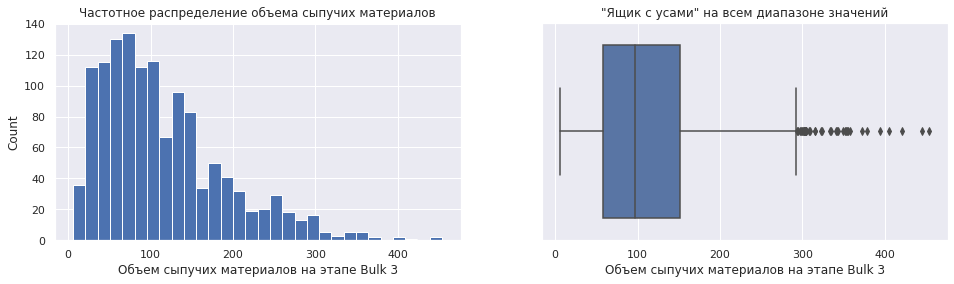

In [ ]:
sns.set(style="darkgrid")
plt.rcParams["figure.figsize"] = (16,4)

plt.subplot(1, 2, 1)
data_bulk['Bulk 3'].plot(kind='hist', bins=30)
plt.title("Частотное распределение объема сыпучих материалов", fontsize=12)
plt.xlabel("Объем сыпучих материалов на этапе Bulk 3")
plt.ylabel("Count")

plt.subplot(1, 2, 2)
sns.boxplot(data=data_bulk, x='Bulk 3')
plt.title('"Ящик с усами" на всем диапазоне значений', fontsize=12)
plt.xlabel("Объем сыпучих материалов на этапе Bulk 3");

In [ ]:
round(np.percentile (data_bulk['Bulk 3'].dropna(), 0))

6

In [ ]:
round(np.percentile (data_bulk['Bulk 3'].dropna(), 100))

454

С учетом рекомендаций бизнеса и технологического процесса, пока оставим как есть. Таким образом, моделирование будем проводит в диапазоне [0, 500].

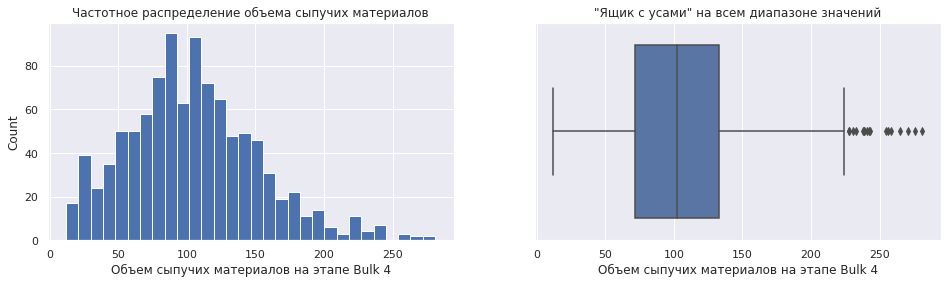

In [ ]:
sns.set(style="darkgrid")
plt.rcParams["figure.figsize"] = (16,4)

plt.subplot(1, 2, 1)
data_bulk['Bulk 4'].plot(kind='hist', bins=30)
plt.title("Частотное распределение объема сыпучих материалов", fontsize=12)
plt.xlabel("Объем сыпучих материалов на этапе Bulk 4")
plt.ylabel("Count")

plt.subplot(1, 2, 2)
sns.boxplot(data=data_bulk, x='Bulk 4')
plt.title('"Ящик с усами" на всем диапазоне значений', fontsize=12)
plt.xlabel("Объем сыпучих материалов на этапе Bulk 4");

In [ ]:
round(np.percentile (data_bulk['Bulk 4'].dropna(), 0))

12

In [ ]:
round(np.percentile (data_bulk['Bulk 4'].dropna(), 100))

281

С учетом рекомендаций бизнеса и технологического процесса, пока оставим как есть. Таким образом, моделирование будем проводит в диапазоне [0, 300].

### Вывод

**Таким образом, для дальнейшего моделирования необходимо вынести следующие тезисы:**

1. так как при моделировании будет решаться задача регрессе, то для нее лучше вообще убрать столбцы с временем, так как модель может начать пытаться найти функциональную связь в датах и времени;
2. исходя из технологического процесса пропуски в таблицах `data_wire` и `data_bulk` обусловлены тем, что на каких-то итерациях процесса просто не добавляли либо проволочных материалов, либо сыпучих материалов, поэтому целесообразно их заполнить нулями;
3. в таблице `data_temp` в столбце "Температура" находится целевой признак и, поэтому мы будем вынуждены удалить строки с пропусками, так же стоит поступить с  супервыбросами, обнаруженными:
    - в таблице `data_arc` столбец «Реактивная мощность» при этом для моделирования возьмём диапазон значений [0, 3.5];
    - в таблице `data_temp` столбец «Температура», при этом для моделирования возьмём диапазон значений [1400, 1705] (целевой признак);
    - в таблице `data_wire` столбец «Wire 1», при этом для моделирования возьмём диапазон значений [0, 260];
    - в таблице `data_wire` столбец «Wire 2», при этом для моделирования возьмём диапазон значений [0, 260];
    - в таблице `data_bulk` столбец «Bulk 12», при этом для моделирования возьмём диапазон значений [0, 1000];
    - в таблице `data_bulk` столбец «Bulk 15», при этом для моделирования возьмём диапазон значений [0, 400].

# План дальнейшего исследования

1. Реализовать тезисы из предыдущего раздела.
2. Объединить все таблицы кроме `data_wire_time` и `data_bulk_time`.
3. Проверка на мультиколлинеарность.
4. Разбить данные на тренировочную и тестовую выборки в соотношении 75:25.
5. Приступить к поиску лучшей модели и подбору гиперпараметров.
6. Проверить качество модели на тестовой выборке.
7. При неудовлетворительных значениях метрики качества повторить пункты 1-5.
8. При удовлетворительных значениях метрики качества оформить выводы.


## Подготовка данных

#### data_wire

In [ ]:
data_wire.head()

,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
0,1,60.059998,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,96.052315,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,91.160157,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,89.063515,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,89.238236,9.11456,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
data_wire = data_wire.fillna(0)

In [ ]:
data_wire

,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
0,1,60.059998,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2,96.052315,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,3,91.160157,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,4,89.063515,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,5,89.238236,9.11456,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...
3076,3237,38.088959,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3077,3238,56.128799,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3078,3239,143.357761,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3079,3240,34.070400,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
data_wire = data_wire[(data_wire['Wire 1'] <= 260) &
                      (data_wire['Wire 2'] <= 260)]

In [ ]:
data_wire

,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
0,1,60.059998,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2,96.052315,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,3,91.160157,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,4,89.063515,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,5,89.238236,9.11456,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...
3076,3237,38.088959,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3077,3238,56.128799,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3078,3239,143.357761,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3079,3240,34.070400,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
data_wire = data_wire[['key', 'Wire 1', 'Wire 2']]

In [ ]:
data_wire

,key,Wire 1,Wire 2
0,1,60.059998,0.00000
1,2,96.052315,0.00000
2,3,91.160157,0.00000
3,4,89.063515,0.00000
4,5,89.238236,9.11456
...,...,...,...
3076,3237,38.088959,0.00000
3077,3238,56.128799,0.00000
3078,3239,143.357761,0.00000
3079,3240,34.070400,0.00000


Столбцы Wire 3 - Wire 7 удалим как не информативные, они содержат от 97.63% до 99.97% пропусков.

ПРОПУСКИ В ДАННЫХ О ПРОВОЛОЧНЫХ МАТЕРИАЛАХ (ОБЪЁМ), %
    
|Столбец|Процент пропусков|
|:------|----------------:|
|key|        0.00|
|Wire 1|     0.84|
|Wire 2|    64.98|
|Wire 6|    97.63|
|Wire 3|    97.96|
|Wire 9|    99.06|
|Wire 8|    99.38|
|Wire 4|    99.55|
|Wire 7|    99.64|
|Wire 5|    99.97|

#### data_bulk

In [ ]:
data_bulk.head()

,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
0,1,NaN,NaN,NaN,43.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,206.0,NaN,150.0,154.0
1,2,NaN,NaN,NaN,73.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,206.0,NaN,149.0,154.0
2,3,NaN,NaN,NaN,34.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,205.0,NaN,152.0,153.0
3,4,NaN,NaN,NaN,81.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,207.0,NaN,153.0,154.0
4,5,NaN,NaN,NaN,78.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,203.0,NaN,151.0,152.0


In [ ]:
data_bulk = data_bulk.fillna(0)

In [ ]:
data_bulk

,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
0,1,0.0,0.0,0.0,43.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,206.0,0.0,150.0,154.0
1,2,0.0,0.0,0.0,73.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,206.0,0.0,149.0,154.0
2,3,0.0,0.0,0.0,34.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,205.0,0.0,152.0,153.0
3,4,0.0,0.0,0.0,81.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,207.0,0.0,153.0,154.0
4,5,0.0,0.0,0.0,78.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,203.0,0.0,151.0,152.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3124,3237,0.0,0.0,170.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,252.0,0.0,130.0,206.0
3125,3238,0.0,0.0,126.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,254.0,0.0,108.0,106.0
3126,3239,0.0,0.0,0.0,0.0,0.0,114.0,0.0,0.0,0.0,0.0,0.0,158.0,0.0,270.0,88.0
3127,3240,0.0,0.0,0.0,0.0,0.0,26.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,192.0,54.0


In [ ]:
data_bulk = data_bulk[(data_bulk['Bulk 14'] <= 700) &
                      (data_bulk['Bulk 12'] <= 1000) & 
                      (data_bulk['Bulk 15'] <= 400) & 
                      (data_bulk['Bulk 3'] <= 500) & 
                      (data_bulk['Bulk 4'] <= 300)]

In [ ]:
data_bulk

,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
0,1,0.0,0.0,0.0,43.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,206.0,0.0,150.0,154.0
1,2,0.0,0.0,0.0,73.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,206.0,0.0,149.0,154.0
2,3,0.0,0.0,0.0,34.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,205.0,0.0,152.0,153.0
3,4,0.0,0.0,0.0,81.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,207.0,0.0,153.0,154.0
4,5,0.0,0.0,0.0,78.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,203.0,0.0,151.0,152.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3124,3237,0.0,0.0,170.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,252.0,0.0,130.0,206.0
3125,3238,0.0,0.0,126.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,254.0,0.0,108.0,106.0
3126,3239,0.0,0.0,0.0,0.0,0.0,114.0,0.0,0.0,0.0,0.0,0.0,158.0,0.0,270.0,88.0
3127,3240,0.0,0.0,0.0,0.0,0.0,26.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,192.0,54.0


Столбцы Bulk 6, Bulk 1, Bulk 11, Bulk 10, Bulk 5, Bulk 7, Bulk 2, Bulk 9, Bulk 13, Bulk 8 удалим как не информативные, они содержат от 81.59% до 99.97% пропусков.

ПРОПУСКИ В ДАННЫХ О ПОДАЧЕ СЫПУЧИХ МАТЕРИАЛАХ (ОБЪЁМ), %
    
|Столбец|Процент пропусков|
|:------|----------------:|
|key|         0.00|
|Bulk 14|    10.32|
|Bulk 12|    21.70|
|Bulk 15|    28.16|
|Bulk 3|     58.52|
|Bulk 4|     67.59|
|Bulk 6|     81.59|
|Bulk 1|     91.95|
|Bulk 11|    94.34|
|Bulk 10|    94.38|
|Bulk 5|     97.54|
|Bulk 7|     99.20|
|Bulk 2|     99.30|
|Bulk 9|     99.39|
|Bulk 13|    99.42|
|Bulk 8|     99.97|

In [ ]:
data_bulk = data_bulk[['key', 'Bulk 14', 'Bulk 12', 'Bulk 15', 'Bulk 3', 'Bulk 4']]

In [ ]:
data_bulk

,key,Bulk 14,Bulk 12,Bulk 15,Bulk 3,Bulk 4
0,1,150.0,206.0,154.0,0.0,43.0
1,2,149.0,206.0,154.0,0.0,73.0
2,3,152.0,205.0,153.0,0.0,34.0
3,4,153.0,207.0,154.0,0.0,81.0
4,5,151.0,203.0,152.0,0.0,78.0
...,...,...,...,...,...,...
3124,3237,130.0,252.0,206.0,170.0,0.0
3125,3238,108.0,254.0,106.0,126.0,0.0
3126,3239,270.0,158.0,88.0,0.0,0.0
3127,3240,192.0,0.0,54.0,0.0,0.0


#### data_temp

In [ ]:
data_temp

,key,Время замера,Температура
0,1,2019-05-03 11:16:18,1571.0
1,1,2019-05-03 11:25:53,1604.0
2,1,2019-05-03 11:29:11,1618.0
3,1,2019-05-03 11:30:01,1601.0
4,1,2019-05-03 11:30:39,1613.0
...,...,...,...
15902,3241,2019-09-01 04:03:30,1586.0
15903,3241,2019-09-01 04:16:12,NaN
15904,3241,2019-09-01 04:22:39,NaN
15905,3241,2019-09-01 04:33:42,NaN


In [ ]:
#переведем столбец с датой в формат даты и времени
data_temp['Время замера'] = pd.to_datetime(data_temp['Время замера'], format = '%Y-%m-%d %H:%M:%S')

In [ ]:
data_temp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15907 entries, 0 to 15906
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   key           15907 non-null  int64         
 1   Время замера  15907 non-null  datetime64[ns]
 2   Температура   13006 non-null  float64       
dtypes: datetime64[ns](1), float64(1), int64(1)
memory usage: 372.9 KB


In [ ]:
data_temp = data_temp.dropna()

In [ ]:
print(len(data_temp))

13006


In [ ]:
data_temp

,key,Время замера,Температура
0,1,2019-05-03 11:16:18,1571.0
1,1,2019-05-03 11:25:53,1604.0
2,1,2019-05-03 11:29:11,1618.0
3,1,2019-05-03 11:30:01,1601.0
4,1,2019-05-03 11:30:39,1613.0
...,...,...,...
15878,3237,2019-08-31 22:44:04,1569.0
15883,3238,2019-08-31 23:30:31,1584.0
15886,3239,2019-09-01 01:31:47,1598.0
15894,3240,2019-09-01 02:39:01,1617.0


##### min_time_data_temp_pivot

In [ ]:
# сводная таблица
min_time_data_temp_pivot = pd.pivot_table(data_temp, index=['key'], values=['Время замера'], aggfunc=['min'])

In [ ]:
# переименование столбцов сводной таблицы
min_time_data_temp_pivot.columns = ['Время замера']

In [ ]:
min_time_data_temp_pivot

,Время замера
key,
1,2019-05-03 11:16:18
2,2019-05-03 11:37:27
3,2019-05-03 12:13:17
4,2019-05-03 12:52:57
5,2019-05-03 13:23:19
...,...
3237,2019-08-31 22:44:04
3238,2019-08-31 23:30:31
3239,2019-09-01 01:31:47


In [ ]:
min_time_data_temp_pivot = min_time_data_temp_pivot.reset_index()

In [ ]:
min_time_data_temp_pivot

,key,Время замера
0,1,2019-05-03 11:16:18
1,2,2019-05-03 11:37:27
2,3,2019-05-03 12:13:17
3,4,2019-05-03 12:52:57
4,5,2019-05-03 13:23:19
...,...,...
3211,3237,2019-08-31 22:44:04
3212,3238,2019-08-31 23:30:31
3213,3239,2019-09-01 01:31:47
3214,3240,2019-09-01 02:39:01


In [ ]:
min_time_data_temp_pivot = min_time_data_temp_pivot.merge(data_temp, how='inner', on='Время замера')

In [ ]:
min_time_data_temp_pivot

,key_x,Время замера,key_y,Температура
0,1,2019-05-03 11:16:18,1,1571.0
1,2,2019-05-03 11:37:27,2,1581.0
2,3,2019-05-03 12:13:17,3,1596.0
3,4,2019-05-03 12:52:57,4,1601.0
4,5,2019-05-03 13:23:19,5,1576.0
...,...,...,...,...
3211,3237,2019-08-31 22:44:04,3237,1569.0
3212,3238,2019-08-31 23:30:31,3238,1584.0
3213,3239,2019-09-01 01:31:47,3239,1598.0
3214,3240,2019-09-01 02:39:01,3240,1617.0


In [ ]:
min_time_data_temp_pivot = min_time_data_temp_pivot.reset_index(drop=True)

In [ ]:
min_time_data_temp_pivot

,key_x,Время замера,key_y,Температура
0,1,2019-05-03 11:16:18,1,1571.0
1,2,2019-05-03 11:37:27,2,1581.0
2,3,2019-05-03 12:13:17,3,1596.0
3,4,2019-05-03 12:52:57,4,1601.0
4,5,2019-05-03 13:23:19,5,1576.0
...,...,...,...,...
3211,3237,2019-08-31 22:44:04,3237,1569.0
3212,3238,2019-08-31 23:30:31,3238,1584.0
3213,3239,2019-09-01 01:31:47,3239,1598.0
3214,3240,2019-09-01 02:39:01,3240,1617.0


In [ ]:
min_time_data_temp_pivot = min_time_data_temp_pivot.drop('key_y', axis=1)

In [ ]:
min_time_data_temp_pivot

,key_x,Время замера,Температура
0,1,2019-05-03 11:16:18,1571.0
1,2,2019-05-03 11:37:27,1581.0
2,3,2019-05-03 12:13:17,1596.0
3,4,2019-05-03 12:52:57,1601.0
4,5,2019-05-03 13:23:19,1576.0
...,...,...,...
3211,3237,2019-08-31 22:44:04,1569.0
3212,3238,2019-08-31 23:30:31,1584.0
3213,3239,2019-09-01 01:31:47,1598.0
3214,3240,2019-09-01 02:39:01,1617.0


In [ ]:
min_time_data_temp_pivot.rename(columns = {'key_x' : 'key', 'Время замера' : 'Начальное время замера', 'Температура' : 'Температура начальная'}, inplace = True)

In [ ]:
min_time_data_temp_pivot

,key,Начальное время замера,Температура начальная
0,1,2019-05-03 11:16:18,1571.0
1,2,2019-05-03 11:37:27,1581.0
2,3,2019-05-03 12:13:17,1596.0
3,4,2019-05-03 12:52:57,1601.0
4,5,2019-05-03 13:23:19,1576.0
...,...,...,...
3211,3237,2019-08-31 22:44:04,1569.0
3212,3238,2019-08-31 23:30:31,1584.0
3213,3239,2019-09-01 01:31:47,1598.0
3214,3240,2019-09-01 02:39:01,1617.0


##### max_time_data_temp_pivot

In [ ]:
# сводная таблица
max_time_data_temp_pivot = pd.pivot_table(data_temp, index=['key'], values=['Время замера'], aggfunc=['max'])

In [ ]:
# переименование столбцов сводной таблицы
max_time_data_temp_pivot.columns = ['Время замера']

In [ ]:
max_time_data_temp_pivot

,Время замера
key,
1,2019-05-03 11:30:39
2,2019-05-03 11:59:12
3,2019-05-03 12:34:57
4,2019-05-03 12:59:25
5,2019-05-03 13:36:01
...,...
3237,2019-08-31 22:44:04
3238,2019-08-31 23:30:31
3239,2019-09-01 01:31:47


In [ ]:
max_time_data_temp_pivot = max_time_data_temp_pivot.reset_index()

In [ ]:
max_time_data_temp_pivot

,key,Время замера
0,1,2019-05-03 11:30:39
1,2,2019-05-03 11:59:12
2,3,2019-05-03 12:34:57
3,4,2019-05-03 12:59:25
4,5,2019-05-03 13:36:01
...,...,...
3211,3237,2019-08-31 22:44:04
3212,3238,2019-08-31 23:30:31
3213,3239,2019-09-01 01:31:47
3214,3240,2019-09-01 02:39:01


In [ ]:
max_time_data_temp_pivot = max_time_data_temp_pivot.merge(data_temp, how='inner', on='Время замера')

In [ ]:
max_time_data_temp_pivot

,key_x,Время замера,key_y,Температура
0,1,2019-05-03 11:30:39,1,1613.0
1,2,2019-05-03 11:59:12,2,1602.0
2,3,2019-05-03 12:34:57,3,1599.0
3,4,2019-05-03 12:59:25,4,1625.0
4,5,2019-05-03 13:36:01,5,1602.0
...,...,...,...,...
3211,3237,2019-08-31 22:44:04,3237,1569.0
3212,3238,2019-08-31 23:30:31,3238,1584.0
3213,3239,2019-09-01 01:31:47,3239,1598.0
3214,3240,2019-09-01 02:39:01,3240,1617.0


In [ ]:
max_time_data_temp_pivot = max_time_data_temp_pivot.reset_index(drop=True)

In [ ]:
max_time_data_temp_pivot

,key_x,Время замера,key_y,Температура
0,1,2019-05-03 11:30:39,1,1613.0
1,2,2019-05-03 11:59:12,2,1602.0
2,3,2019-05-03 12:34:57,3,1599.0
3,4,2019-05-03 12:59:25,4,1625.0
4,5,2019-05-03 13:36:01,5,1602.0
...,...,...,...,...
3211,3237,2019-08-31 22:44:04,3237,1569.0
3212,3238,2019-08-31 23:30:31,3238,1584.0
3213,3239,2019-09-01 01:31:47,3239,1598.0
3214,3240,2019-09-01 02:39:01,3240,1617.0


In [ ]:
max_time_data_temp_pivot = max_time_data_temp_pivot.drop('key_y', axis=1)

In [ ]:
max_time_data_temp_pivot

,key_x,Время замера,Температура
0,1,2019-05-03 11:30:39,1613.0
1,2,2019-05-03 11:59:12,1602.0
2,3,2019-05-03 12:34:57,1599.0
3,4,2019-05-03 12:59:25,1625.0
4,5,2019-05-03 13:36:01,1602.0
...,...,...,...
3211,3237,2019-08-31 22:44:04,1569.0
3212,3238,2019-08-31 23:30:31,1584.0
3213,3239,2019-09-01 01:31:47,1598.0
3214,3240,2019-09-01 02:39:01,1617.0


In [ ]:
max_time_data_temp_pivot.rename(columns = {'key_x' : 'key', 'Время замера' : 'Конечное время замера', 'Температура' : 'Температура конечная'}, inplace = True)

In [ ]:
max_time_data_temp_pivot

,key,Конечное время замера,Температура конечная
0,1,2019-05-03 11:30:39,1613.0
1,2,2019-05-03 11:59:12,1602.0
2,3,2019-05-03 12:34:57,1599.0
3,4,2019-05-03 12:59:25,1625.0
4,5,2019-05-03 13:36:01,1602.0
...,...,...,...
3211,3237,2019-08-31 22:44:04,1569.0
3212,3238,2019-08-31 23:30:31,1584.0
3213,3239,2019-09-01 01:31:47,1598.0
3214,3240,2019-09-01 02:39:01,1617.0


In [ ]:
full_pivot_data_temp = max_time_data_temp_pivot.merge(min_time_data_temp_pivot, how='inner', on='key')

In [ ]:
full_pivot_data_temp

,key,Конечное время замера,Температура конечная,Начальное время замера,Температура начальная
0,1,2019-05-03 11:30:39,1613.0,2019-05-03 11:16:18,1571.0
1,2,2019-05-03 11:59:12,1602.0,2019-05-03 11:37:27,1581.0
2,3,2019-05-03 12:34:57,1599.0,2019-05-03 12:13:17,1596.0
3,4,2019-05-03 12:59:25,1625.0,2019-05-03 12:52:57,1601.0
4,5,2019-05-03 13:36:01,1602.0,2019-05-03 13:23:19,1576.0
...,...,...,...,...,...
3211,3237,2019-08-31 22:44:04,1569.0,2019-08-31 22:44:04,1569.0
3212,3238,2019-08-31 23:30:31,1584.0,2019-08-31 23:30:31,1584.0
3213,3239,2019-09-01 01:31:47,1598.0,2019-09-01 01:31:47,1598.0
3214,3240,2019-09-01 02:39:01,1617.0,2019-09-01 02:39:01,1617.0


In [ ]:
full_pivot_data_temp['times_temp'] = (full_pivot_data_temp['Конечное время замера'] - 
                                      full_pivot_data_temp['Начальное время замера'])

In [ ]:
full_pivot_data_temp

,key,Конечное время замера,Температура конечная,Начальное время замера,Температура начальная,times_temp
0,1,2019-05-03 11:30:39,1613.0,2019-05-03 11:16:18,1571.0,0 days 00:14:21
1,2,2019-05-03 11:59:12,1602.0,2019-05-03 11:37:27,1581.0,0 days 00:21:45
2,3,2019-05-03 12:34:57,1599.0,2019-05-03 12:13:17,1596.0,0 days 00:21:40
3,4,2019-05-03 12:59:25,1625.0,2019-05-03 12:52:57,1601.0,0 days 00:06:28
4,5,2019-05-03 13:36:01,1602.0,2019-05-03 13:23:19,1576.0,0 days 00:12:42
...,...,...,...,...,...,...
3211,3237,2019-08-31 22:44:04,1569.0,2019-08-31 22:44:04,1569.0,0 days 00:00:00
3212,3238,2019-08-31 23:30:31,1584.0,2019-08-31 23:30:31,1584.0,0 days 00:00:00
3213,3239,2019-09-01 01:31:47,1598.0,2019-09-01 01:31:47,1598.0,0 days 00:00:00
3214,3240,2019-09-01 02:39:01,1617.0,2019-09-01 02:39:01,1617.0,0 days 00:00:00


In [ ]:
full_pivot_data_temp = full_pivot_data_temp[(full_pivot_data_temp['Температура конечная'] !=
                                             full_pivot_data_temp['Температура начальная'])]

In [ ]:
full_pivot_data_temp

,key,Конечное время замера,Температура конечная,Начальное время замера,Температура начальная,times_temp
0,1,2019-05-03 11:30:39,1613.0,2019-05-03 11:16:18,1571.0,0 days 00:14:21
1,2,2019-05-03 11:59:12,1602.0,2019-05-03 11:37:27,1581.0,0 days 00:21:45
2,3,2019-05-03 12:34:57,1599.0,2019-05-03 12:13:17,1596.0,0 days 00:21:40
3,4,2019-05-03 12:59:25,1625.0,2019-05-03 12:52:57,1601.0,0 days 00:06:28
4,5,2019-05-03 13:36:01,1602.0,2019-05-03 13:23:19,1576.0,0 days 00:12:42
...,...,...,...,...,...,...
2472,2495,2019-08-06 00:54:42,1591.0,2019-08-06 00:35:45,1570.0,0 days 00:18:57
2473,2496,2019-08-06 01:29:52,1591.0,2019-08-06 01:02:54,1554.0,0 days 00:26:58
2474,2497,2019-08-06 01:53:50,1589.0,2019-08-06 01:41:53,1571.0,0 days 00:11:57
2475,2498,2019-08-06 02:25:31,1594.0,2019-08-06 02:03:49,1591.0,0 days 00:21:42


Так как продолжительность процесса - это важный момент. Сделаем дополнительные фичи по часам и минутам.

In [ ]:
full_pivot_data_temp['minutes_temp'] = full_pivot_data_temp['times_temp'].dt.components['minutes']

In [ ]:
full_pivot_data_temp['hours_temp'] = full_pivot_data_temp['times_temp'].dt.components['hours']

In [ ]:
full_pivot_data_temp['hours_temp'].describe()

count    2433.000000
mean        0.056309
std         0.330275
min         0.000000
25%         0.000000
50%         0.000000
75%         0.000000
max         6.000000
Name: hours_temp, dtype: float64

In [ ]:
full_pivot_data_temp.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2433 entries, 0 to 2476
Data columns (total 8 columns):
 #   Column                  Non-Null Count  Dtype          
---  ------                  --------------  -----          
 0   key                     2433 non-null   int64          
 1   Конечное время замера   2433 non-null   datetime64[ns] 
 2   Температура конечная    2433 non-null   float64        
 3   Начальное время замера  2433 non-null   datetime64[ns] 
 4   Температура начальная   2433 non-null   float64        
 5   times_temp              2433 non-null   timedelta64[ns]
 6   minutes_temp            2433 non-null   int64          
 7   hours_temp              2433 non-null   int64          
dtypes: datetime64[ns](2), float64(2), int64(3), timedelta64[ns](1)
memory usage: 171.1 KB


In [ ]:
full_pivot_data_temp

,key,Конечное время замера,Температура конечная,Начальное время замера,Температура начальная,times_temp,minutes_temp,hours_temp
0,1,2019-05-03 11:30:39,1613.0,2019-05-03 11:16:18,1571.0,0 days 00:14:21,14,0
1,2,2019-05-03 11:59:12,1602.0,2019-05-03 11:37:27,1581.0,0 days 00:21:45,21,0
2,3,2019-05-03 12:34:57,1599.0,2019-05-03 12:13:17,1596.0,0 days 00:21:40,21,0
3,4,2019-05-03 12:59:25,1625.0,2019-05-03 12:52:57,1601.0,0 days 00:06:28,6,0
4,5,2019-05-03 13:36:01,1602.0,2019-05-03 13:23:19,1576.0,0 days 00:12:42,12,0
...,...,...,...,...,...,...,...,...
2472,2495,2019-08-06 00:54:42,1591.0,2019-08-06 00:35:45,1570.0,0 days 00:18:57,18,0
2473,2496,2019-08-06 01:29:52,1591.0,2019-08-06 01:02:54,1554.0,0 days 00:26:58,26,0
2474,2497,2019-08-06 01:53:50,1589.0,2019-08-06 01:41:53,1571.0,0 days 00:11:57,11,0
2475,2498,2019-08-06 02:25:31,1594.0,2019-08-06 02:03:49,1591.0,0 days 00:21:42,21,0


In [ ]:
full_pivot_data_temp = full_pivot_data_temp.drop(['Конечное время замера', 'Начальное время замера', 'times_temp'], axis=1)

In [ ]:
full_pivot_data_temp

,key,Температура конечная,Температура начальная,minutes_temp,hours_temp
0,1,1613.0,1571.0,14,0
1,2,1602.0,1581.0,21,0
2,3,1599.0,1596.0,21,0
3,4,1625.0,1601.0,6,0
4,5,1602.0,1576.0,12,0
...,...,...,...,...,...
2472,2495,1591.0,1570.0,18,0
2473,2496,1591.0,1554.0,26,0
2474,2497,1589.0,1571.0,11,0
2475,2498,1594.0,1591.0,21,0


In [ ]:
full_pivot_data_temp = full_pivot_data_temp[(full_pivot_data_temp['Температура начальная'] >= 1400) &
                      (full_pivot_data_temp['Температура конечная'] <= 1705)]

In [ ]:
full_pivot_data_temp

,key,Температура конечная,Температура начальная,minutes_temp,hours_temp
0,1,1613.0,1571.0,14,0
1,2,1602.0,1581.0,21,0
2,3,1599.0,1596.0,21,0
3,4,1625.0,1601.0,6,0
4,5,1602.0,1576.0,12,0
...,...,...,...,...,...
2472,2495,1591.0,1570.0,18,0
2473,2496,1591.0,1554.0,26,0
2474,2497,1589.0,1571.0,11,0
2475,2498,1594.0,1591.0,21,0


#### data_arc

In [ ]:
#переведем столбец с датой в формат даты и времени
data_arc['Начало нагрева дугой'] = pd.to_datetime(data_arc['Начало нагрева дугой'], format = '%Y-%m-%d %H:%M:%S')
data_arc['Конец нагрева дугой'] = pd.to_datetime(data_arc['Конец нагрева дугой'], format = '%Y-%m-%d %H:%M:%S')

**Понятие [полной мощности](https://odinelectric.ru/knowledgebase/aktivnaja-i-reaktivnaja-moshhnost-peremennogo-toka).**

Полная мощность – это геометрически вычисляемая величина, равная корню из суммы квадратов активной (P) и реактивной (Q) мощностей соответственно. Обозначается латинской буквой S.

$$
S = (P^{2} + Q^{2})^{1/2}
$$


In [ ]:
data_arc

,key,Начало нагрева дугой,Конец нагрева дугой,Активная мощность,Реактивная мощность
0,1,2019-05-03 11:02:14,2019-05-03 11:06:02,0.976059,0.687084
1,1,2019-05-03 11:07:28,2019-05-03 11:10:33,0.805607,0.520285
2,1,2019-05-03 11:11:44,2019-05-03 11:14:36,0.744363,0.498805
3,1,2019-05-03 11:18:14,2019-05-03 11:24:19,1.659363,1.062669
4,1,2019-05-03 11:26:09,2019-05-03 11:28:37,0.692755,0.414397
...,...,...,...,...,...
14871,3241,2019-09-01 03:58:58,2019-09-01 04:01:35,0.533670,0.354439
14872,3241,2019-09-01 04:05:04,2019-09-01 04:08:04,0.676604,0.523631
14873,3241,2019-09-01 04:16:41,2019-09-01 04:19:45,0.733899,0.475654
14874,3241,2019-09-01 04:31:51,2019-09-01 04:32:48,0.220694,0.145768


In [ ]:
data_arc = data_arc[(data_arc['Активная мощность'] <= 3.5) &
                    (data_arc['Активная мощность'] > 0) &
                    (data_arc['Реактивная мощность'] <= 3.5) &
                    (data_arc['Реактивная мощность'] > 0)]

In [ ]:
data_arc['s'] = (data_arc['Активная мощность']**2 + data_arc['Реактивная мощность']**2)**0.5

In [ ]:
data_arc

,key,Начало нагрева дугой,Конец нагрева дугой,Активная мощность,Реактивная мощность,s
0,1,2019-05-03 11:02:14,2019-05-03 11:06:02,0.976059,0.687084,1.193639
1,1,2019-05-03 11:07:28,2019-05-03 11:10:33,0.805607,0.520285,0.959010
2,1,2019-05-03 11:11:44,2019-05-03 11:14:36,0.744363,0.498805,0.896038
3,1,2019-05-03 11:18:14,2019-05-03 11:24:19,1.659363,1.062669,1.970470
4,1,2019-05-03 11:26:09,2019-05-03 11:28:37,0.692755,0.414397,0.807239
...,...,...,...,...,...,...
14871,3241,2019-09-01 03:58:58,2019-09-01 04:01:35,0.533670,0.354439,0.640648
14872,3241,2019-09-01 04:05:04,2019-09-01 04:08:04,0.676604,0.523631,0.855559
14873,3241,2019-09-01 04:16:41,2019-09-01 04:19:45,0.733899,0.475654,0.874560
14874,3241,2019-09-01 04:31:51,2019-09-01 04:32:48,0.220694,0.145768,0.264489


In [ ]:
# сводная таблица
min_time_data_arc_pivot = pd.pivot_table(data_arc, index=['key'], values=['Начало нагрева дугой'], aggfunc=['min'])

In [ ]:
# сводная таблица
max_time_data_arc_pivot = pd.pivot_table(data_arc, index=['key'], values=['Конец нагрева дугой'], aggfunc=['max'])

In [ ]:
# сводная таблица
p_data_arc_pivot = pd.pivot_table(data_arc, index=['key'], values=['Активная мощность'], aggfunc=['min', 'max'])

In [ ]:
# сводная таблица
q_data_arc_pivot = pd.pivot_table(data_arc, index=['key'], values=['Реактивная мощность'], aggfunc=['min', 'max'])

In [ ]:
# сводная таблица
s_data_arc_pivot = pd.pivot_table(data_arc, index=['key'], values=['s'], aggfunc=['min', 'max'])

In [ ]:
# переименование столбцов сводной таблицы
min_time_data_arc_pivot.columns = ['min_time_power']
min_time_data_arc_pivot = min_time_data_arc_pivot.reset_index()

In [ ]:
min_time_data_arc_pivot

,key,min_time_power
0,1,2019-05-03 11:02:14
1,2,2019-05-03 11:34:14
2,3,2019-05-03 12:06:54
3,4,2019-05-03 12:39:37
4,5,2019-05-03 13:11:13
...,...,...
3209,3237,2019-08-31 22:41:18
3210,3238,2019-08-31 23:26:18
3211,3239,2019-09-01 01:26:53
3212,3240,2019-09-01 02:35:24


In [ ]:
# переименование столбцов сводной таблицы
max_time_data_arc_pivot.columns = ['max_time_power']
max_time_data_arc_pivot = max_time_data_arc_pivot.reset_index()

In [ ]:
full_times_arc = min_time_data_arc_pivot.merge(max_time_data_arc_pivot, how='inner', on='key')

In [ ]:
full_times_arc['times_arc'] = full_times_arc['max_time_power'] - full_times_arc['min_time_power']

In [ ]:
full_times_arc

,key,min_time_power,max_time_power,times_arc
0,1,2019-05-03 11:02:14,2019-05-03 11:28:37,0 days 00:26:23
1,2,2019-05-03 11:34:14,2019-05-03 11:53:18,0 days 00:19:04
2,3,2019-05-03 12:06:54,2019-05-03 12:32:19,0 days 00:25:25
3,4,2019-05-03 12:39:37,2019-05-03 12:57:50,0 days 00:18:13
4,5,2019-05-03 13:11:13,2019-05-03 13:33:55,0 days 00:22:42
...,...,...,...,...
3209,3237,2019-08-31 22:41:18,2019-08-31 23:03:48,0 days 00:22:30
3210,3238,2019-08-31 23:26:18,2019-08-31 23:41:28,0 days 00:15:10
3211,3239,2019-09-01 01:26:53,2019-09-01 02:15:43,0 days 00:48:50
3212,3240,2019-09-01 02:35:24,2019-09-01 03:34:08,0 days 00:58:44


In [ ]:
full_times_arc = full_times_arc.drop(['min_time_power', 'max_time_power'], axis=1)

In [ ]:
full_times_arc

,key,times_arc
0,1,0 days 00:26:23
1,2,0 days 00:19:04
2,3,0 days 00:25:25
3,4,0 days 00:18:13
4,5,0 days 00:22:42
...,...,...
3209,3237,0 days 00:22:30
3210,3238,0 days 00:15:10
3211,3239,0 days 00:48:50
3212,3240,0 days 00:58:44


In [ ]:
# переименование столбцов сводной таблицы
p_data_arc_pivot.columns = ['min_p', 'max_p']
p_data_arc_pivot = p_data_arc_pivot.reset_index()

In [ ]:
p_data_arc_pivot

,key,min_p,max_p
0,1,0.692755,1.659363
1,2,0.438063,1.296415
2,3,0.250280,1.062053
3,4,0.425692,1.220955
4,5,0.267457,1.621665
...,...,...,...
3209,3237,0.405685,1.060122
3210,3238,0.371511,1.017459
3211,3239,0.205792,1.156764
3212,3240,0.411601,0.983723


In [ ]:
# переименование столбцов сводной таблицы
q_data_arc_pivot.columns = ['min_q', 'max_q']
q_data_arc_pivot = q_data_arc_pivot.reset_index()

In [ ]:
q_data_arc_pivot

,key,min_q,max_q
0,1,0.414397,1.062669
1,2,0.283043,0.892914
2,3,0.155901,0.671494
3,4,0.268482,0.754719
4,5,0.181992,1.047776
...,...,...,...
3209,3237,0.320431,0.784557
3210,3238,0.309811,0.850749
3211,3239,0.135075,0.725063
3212,3240,0.274390,0.884585


In [ ]:
# переименование столбцов сводной таблицы
s_data_arc_pivot.columns = ['min_s', 'max_s']
s_data_arc_pivot = s_data_arc_pivot.reset_index()

In [ ]:
s_data_arc_pivot

,key,min_s,max_s
0,1,0.807239,1.970470
1,2,0.521549,1.574162
2,3,0.294865,1.256527
3,4,0.503286,1.435385
4,5,0.323503,1.930707
...,...,...,...
3209,3237,0.516969,1.318859
3210,3238,0.483738,1.326271
3211,3239,0.246162,1.365218
3212,3240,0.494677,1.322952


In [ ]:
full_pivot_arc = full_times_arc.merge(p_data_arc_pivot, how='inner', on='key')
full_pivot_arc = full_pivot_arc.merge(q_data_arc_pivot, how='inner', on='key')
full_pivot_arc = full_pivot_arc.merge(s_data_arc_pivot, how='inner', on='key')

In [ ]:
full_pivot_arc

,key,times_arc,min_p,max_p,min_q,max_q,min_s,max_s
0,1,0 days 00:26:23,0.692755,1.659363,0.414397,1.062669,0.807239,1.970470
1,2,0 days 00:19:04,0.438063,1.296415,0.283043,0.892914,0.521549,1.574162
2,3,0 days 00:25:25,0.250280,1.062053,0.155901,0.671494,0.294865,1.256527
3,4,0 days 00:18:13,0.425692,1.220955,0.268482,0.754719,0.503286,1.435385
4,5,0 days 00:22:42,0.267457,1.621665,0.181992,1.047776,0.323503,1.930707
...,...,...,...,...,...,...,...,...
3209,3237,0 days 00:22:30,0.405685,1.060122,0.320431,0.784557,0.516969,1.318859
3210,3238,0 days 00:15:10,0.371511,1.017459,0.309811,0.850749,0.483738,1.326271
3211,3239,0 days 00:48:50,0.205792,1.156764,0.135075,0.725063,0.246162,1.365218
3212,3240,0 days 00:58:44,0.411601,0.983723,0.274390,0.884585,0.494677,1.322952


Аналогично предыдущим выкладкам, сделаем дополнительные фичи по часам и минутам.

In [ ]:
full_pivot_arc['minutes_arc'] = full_pivot_arc['times_arc'].dt.components['minutes']

In [ ]:
full_pivot_arc['hours_arc'] = full_pivot_arc['times_arc'].dt.components['hours']

In [ ]:
full_pivot_arc

,key,times_arc,min_p,max_p,min_q,max_q,min_s,max_s,minutes_arc,hours_arc
0,1,0 days 00:26:23,0.692755,1.659363,0.414397,1.062669,0.807239,1.970470,26,0
1,2,0 days 00:19:04,0.438063,1.296415,0.283043,0.892914,0.521549,1.574162,19,0
2,3,0 days 00:25:25,0.250280,1.062053,0.155901,0.671494,0.294865,1.256527,25,0
3,4,0 days 00:18:13,0.425692,1.220955,0.268482,0.754719,0.503286,1.435385,18,0
4,5,0 days 00:22:42,0.267457,1.621665,0.181992,1.047776,0.323503,1.930707,22,0
...,...,...,...,...,...,...,...,...,...,...
3209,3237,0 days 00:22:30,0.405685,1.060122,0.320431,0.784557,0.516969,1.318859,22,0
3210,3238,0 days 00:15:10,0.371511,1.017459,0.309811,0.850749,0.483738,1.326271,15,0
3211,3239,0 days 00:48:50,0.205792,1.156764,0.135075,0.725063,0.246162,1.365218,48,0
3212,3240,0 days 00:58:44,0.411601,0.983723,0.274390,0.884585,0.494677,1.322952,58,0


In [ ]:
full_pivot_arc = full_pivot_arc.drop(['times_arc'], axis=1)

In [ ]:
full_pivot_arc['hours_arc'].describe()

count    3214.000000
mean        0.057250
std         0.316309
min         0.000000
25%         0.000000
50%         0.000000
75%         0.000000
max         6.000000
Name: hours_arc, dtype: float64

In [ ]:
full_pivot_arc.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3214 entries, 0 to 3213
Data columns (total 9 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   key          3214 non-null   int64  
 1   min_p        3214 non-null   float64
 2   max_p        3214 non-null   float64
 3   min_q        3214 non-null   float64
 4   max_q        3214 non-null   float64
 5   min_s        3214 non-null   float64
 6   max_s        3214 non-null   float64
 7   minutes_arc  3214 non-null   int64  
 8   hours_arc    3214 non-null   int64  
dtypes: float64(6), int64(3)
memory usage: 251.1 KB


In [ ]:
full_pivot_arc

,key,min_p,max_p,min_q,max_q,min_s,max_s,minutes_arc,hours_arc
0,1,0.692755,1.659363,0.414397,1.062669,0.807239,1.970470,26,0
1,2,0.438063,1.296415,0.283043,0.892914,0.521549,1.574162,19,0
2,3,0.250280,1.062053,0.155901,0.671494,0.294865,1.256527,25,0
3,4,0.425692,1.220955,0.268482,0.754719,0.503286,1.435385,18,0
4,5,0.267457,1.621665,0.181992,1.047776,0.323503,1.930707,22,0
...,...,...,...,...,...,...,...,...,...
3209,3237,0.405685,1.060122,0.320431,0.784557,0.516969,1.318859,22,0
3210,3238,0.371511,1.017459,0.309811,0.850749,0.483738,1.326271,15,0
3211,3239,0.205792,1.156764,0.135075,0.725063,0.246162,1.365218,48,0
3212,3240,0.411601,0.983723,0.274390,0.884585,0.494677,1.322952,58,0


#### Объединение всех таблиц

In [ ]:
full_pivot_merge = full_pivot_data_temp.merge(full_pivot_arc, how='inner', on='key')

In [ ]:
full_pivot_merge

,key,Температура конечная,Температура начальная,minutes_temp,hours_temp,min_p,max_p,min_q,max_q,min_s,max_s,minutes_arc,hours_arc
0,1,1613.0,1571.0,14,0,0.692755,1.659363,0.414397,1.062669,0.807239,1.970470,26,0
1,2,1602.0,1581.0,21,0,0.438063,1.296415,0.283043,0.892914,0.521549,1.574162,19,0
2,3,1599.0,1596.0,21,0,0.250280,1.062053,0.155901,0.671494,0.294865,1.256527,25,0
3,4,1625.0,1601.0,6,0,0.425692,1.220955,0.268482,0.754719,0.503286,1.435385,18,0
4,5,1602.0,1576.0,12,0,0.267457,1.621665,0.181992,1.047776,0.323503,1.930707,22,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2424,2495,1591.0,1570.0,18,0,0.435236,1.062164,0.304878,0.769281,0.531395,1.311482,20,0
2425,2496,1591.0,1554.0,26,0,0.393625,1.049800,0.287355,0.701201,0.487354,1.262444,23,0
2426,2497,1589.0,1571.0,11,0,0.580983,0.834539,0.504512,0.701218,0.769463,1.090028,12,0
2427,2498,1594.0,1591.0,21,0,0.180213,1.162895,0.116065,0.832519,0.214355,1.430179,22,0


In [ ]:
full_pivot_merge = full_pivot_merge.merge(data_bulk, how='inner', on='key')

In [ ]:
full_pivot_merge = full_pivot_merge.merge(data_wire, how='inner', on='key')

In [ ]:
full_pivot_merge

,key,Температура конечная,Температура начальная,minutes_temp,hours_temp,min_p,max_p,min_q,max_q,min_s,max_s,minutes_arc,hours_arc,Bulk 14,Bulk 12,Bulk 15,Bulk 3,Bulk 4,Wire 1,Wire 2
0,1,1613.0,1571.0,14,0,0.692755,1.659363,0.414397,1.062669,0.807239,1.970470,26,0,150.0,206.0,154.0,0.0,43.0,60.059998,0.00000
1,2,1602.0,1581.0,21,0,0.438063,1.296415,0.283043,0.892914,0.521549,1.574162,19,0,149.0,206.0,154.0,0.0,73.0,96.052315,0.00000
2,3,1599.0,1596.0,21,0,0.250280,1.062053,0.155901,0.671494,0.294865,1.256527,25,0,152.0,205.0,153.0,0.0,34.0,91.160157,0.00000
3,4,1625.0,1601.0,6,0,0.425692,1.220955,0.268482,0.754719,0.503286,1.435385,18,0,153.0,207.0,154.0,0.0,81.0,89.063515,0.00000
4,5,1602.0,1576.0,12,0,0.267457,1.621665,0.181992,1.047776,0.323503,1.930707,22,0,151.0,203.0,152.0,0.0,78.0,89.238236,9.11456
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2280,2495,1591.0,1570.0,18,0,0.435236,1.062164,0.304878,0.769281,0.531395,1.311482,20,0,129.0,256.0,223.0,21.0,0.0,89.150879,0.00000
2281,2496,1591.0,1554.0,26,0,0.393625,1.049800,0.287355,0.701201,0.487354,1.262444,23,0,129.0,256.0,226.0,0.0,63.0,114.179527,0.00000
2282,2497,1589.0,1571.0,11,0,0.580983,0.834539,0.504512,0.701218,0.769463,1.090028,12,0,124.0,230.0,226.0,0.0,85.0,94.086723,9.04800
2283,2498,1594.0,1591.0,21,0,0.180213,1.162895,0.116065,0.832519,0.214355,1.430179,22,0,129.0,206.0,207.0,90.0,0.0,118.110717,0.00000


In [ ]:
full_pivot_merge.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2285 entries, 0 to 2284
Data columns (total 20 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   key                    2285 non-null   int64  
 1   Температура конечная   2285 non-null   float64
 2   Температура начальная  2285 non-null   float64
 3   minutes_temp           2285 non-null   int64  
 4   hours_temp             2285 non-null   int64  
 5   min_p                  2285 non-null   float64
 6   max_p                  2285 non-null   float64
 7   min_q                  2285 non-null   float64
 8   max_q                  2285 non-null   float64
 9   min_s                  2285 non-null   float64
 10  max_s                  2285 non-null   float64
 11  minutes_arc            2285 non-null   int64  
 12  hours_arc              2285 non-null   int64  
 13  Bulk 14                2285 non-null   float64
 14  Bulk 12                2285 non-null   float64
 15  Bulk

In [ ]:
display(round((full_pivot_merge.isna().sum() / len(dat)) * 100, 2).sort_values())

key                      0.0
Bulk 4                   0.0
Bulk 3                   0.0
Bulk 15                  0.0
Bulk 12                  0.0
Bulk 14                  0.0
hours_arc                0.0
minutes_arc              0.0
max_s                    0.0
min_s                    0.0
max_q                    0.0
min_q                    0.0
max_p                    0.0
min_p                    0.0
hours_temp               0.0
minutes_temp             0.0
Температура начальная    0.0
Температура конечная     0.0
Wire 1                   0.0
Wire 2                   0.0
dtype: float64

In [ ]:
full_pivot_merge

,key,Температура конечная,Температура начальная,minutes_temp,hours_temp,min_p,max_p,min_q,max_q,min_s,max_s,minutes_arc,hours_arc,Bulk 14,Bulk 12,Bulk 15,Bulk 3,Bulk 4,Wire 1,Wire 2
0,1,1613.0,1571.0,14,0,0.692755,1.659363,0.414397,1.062669,0.807239,1.970470,26,0,150.0,206.0,154.0,0.0,43.0,60.059998,0.00000
1,2,1602.0,1581.0,21,0,0.438063,1.296415,0.283043,0.892914,0.521549,1.574162,19,0,149.0,206.0,154.0,0.0,73.0,96.052315,0.00000
2,3,1599.0,1596.0,21,0,0.250280,1.062053,0.155901,0.671494,0.294865,1.256527,25,0,152.0,205.0,153.0,0.0,34.0,91.160157,0.00000
3,4,1625.0,1601.0,6,0,0.425692,1.220955,0.268482,0.754719,0.503286,1.435385,18,0,153.0,207.0,154.0,0.0,81.0,89.063515,0.00000
4,5,1602.0,1576.0,12,0,0.267457,1.621665,0.181992,1.047776,0.323503,1.930707,22,0,151.0,203.0,152.0,0.0,78.0,89.238236,9.11456
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2280,2495,1591.0,1570.0,18,0,0.435236,1.062164,0.304878,0.769281,0.531395,1.311482,20,0,129.0,256.0,223.0,21.0,0.0,89.150879,0.00000
2281,2496,1591.0,1554.0,26,0,0.393625,1.049800,0.287355,0.701201,0.487354,1.262444,23,0,129.0,256.0,226.0,0.0,63.0,114.179527,0.00000
2282,2497,1589.0,1571.0,11,0,0.580983,0.834539,0.504512,0.701218,0.769463,1.090028,12,0,124.0,230.0,226.0,0.0,85.0,94.086723,9.04800
2283,2498,1594.0,1591.0,21,0,0.180213,1.162895,0.116065,0.832519,0.214355,1.430179,22,0,129.0,206.0,207.0,90.0,0.0,118.110717,0.00000


In [ ]:
full_pivot_merge.rename(columns = {'Температура конечная' : 't_end',
                                   'Температура начальная' : 't_start',
                                   'Bulk 14' : 'b_14',
                                   'Bulk 12' : 'b_12',
                                   'Bulk 15' : 'b_15',
                                   'Bulk 3' : 'b_3',
                                   'Bulk 4' : 'b_4',
                                   'Wire 1' : 'w_1',
                                   'Wire 2' : 'w_2'}, inplace = True)

In [ ]:
full_pivot_merge

,key,t_end,t_start,minutes_temp,hours_temp,min_p,max_p,min_q,max_q,min_s,max_s,minutes_arc,hours_arc,b_14,b_12,b_15,b_3,b_4,w_1,w_2
0,1,1613.0,1571.0,14,0,0.692755,1.659363,0.414397,1.062669,0.807239,1.970470,26,0,150.0,206.0,154.0,0.0,43.0,60.059998,0.00000
1,2,1602.0,1581.0,21,0,0.438063,1.296415,0.283043,0.892914,0.521549,1.574162,19,0,149.0,206.0,154.0,0.0,73.0,96.052315,0.00000
2,3,1599.0,1596.0,21,0,0.250280,1.062053,0.155901,0.671494,0.294865,1.256527,25,0,152.0,205.0,153.0,0.0,34.0,91.160157,0.00000
3,4,1625.0,1601.0,6,0,0.425692,1.220955,0.268482,0.754719,0.503286,1.435385,18,0,153.0,207.0,154.0,0.0,81.0,89.063515,0.00000
4,5,1602.0,1576.0,12,0,0.267457,1.621665,0.181992,1.047776,0.323503,1.930707,22,0,151.0,203.0,152.0,0.0,78.0,89.238236,9.11456
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2280,2495,1591.0,1570.0,18,0,0.435236,1.062164,0.304878,0.769281,0.531395,1.311482,20,0,129.0,256.0,223.0,21.0,0.0,89.150879,0.00000
2281,2496,1591.0,1554.0,26,0,0.393625,1.049800,0.287355,0.701201,0.487354,1.262444,23,0,129.0,256.0,226.0,0.0,63.0,114.179527,0.00000
2282,2497,1589.0,1571.0,11,0,0.580983,0.834539,0.504512,0.701218,0.769463,1.090028,12,0,124.0,230.0,226.0,0.0,85.0,94.086723,9.04800
2283,2498,1594.0,1591.0,21,0,0.180213,1.162895,0.116065,0.832519,0.214355,1.430179,22,0,129.0,206.0,207.0,90.0,0.0,118.110717,0.00000


In [ ]:
null_in_full_pivot_merge = full_pivot_merge.query('b_14 == 0 & b_12 == 0 & b_15 == 0 & b_3 == 0 & b_4 == 0 & w_2 == 0 & w_1 == 0')

In [ ]:
null_in_full_pivot_merge

,key,t_end,t_start,minutes_temp,hours_temp,min_p,max_p,min_q,max_q,min_s,max_s,minutes_arc,hours_arc,b_14,b_12,b_15,b_3,b_4,w_1,w_2
94,114,1600.0,1631.0,48,0,0.477073,0.931495,0.410262,0.703216,0.629217,1.167131,58,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
null_in_full_pivot_merge.index

Int64Index([94], dtype='int64')

In [ ]:
full_pivot_merge = full_pivot_merge.drop(null_in_full_pivot_merge.index)
full_pivot_merge = full_pivot_merge.reset_index(drop=True)

In [ ]:
full_pivot_merge

,key,t_end,t_start,minutes_temp,hours_temp,min_p,max_p,min_q,max_q,min_s,max_s,minutes_arc,hours_arc,b_14,b_12,b_15,b_3,b_4,w_1,w_2
0,1,1613.0,1571.0,14,0,0.692755,1.659363,0.414397,1.062669,0.807239,1.970470,26,0,150.0,206.0,154.0,0.0,43.0,60.059998,0.00000
1,2,1602.0,1581.0,21,0,0.438063,1.296415,0.283043,0.892914,0.521549,1.574162,19,0,149.0,206.0,154.0,0.0,73.0,96.052315,0.00000
2,3,1599.0,1596.0,21,0,0.250280,1.062053,0.155901,0.671494,0.294865,1.256527,25,0,152.0,205.0,153.0,0.0,34.0,91.160157,0.00000
3,4,1625.0,1601.0,6,0,0.425692,1.220955,0.268482,0.754719,0.503286,1.435385,18,0,153.0,207.0,154.0,0.0,81.0,89.063515,0.00000
4,5,1602.0,1576.0,12,0,0.267457,1.621665,0.181992,1.047776,0.323503,1.930707,22,0,151.0,203.0,152.0,0.0,78.0,89.238236,9.11456
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2279,2495,1591.0,1570.0,18,0,0.435236,1.062164,0.304878,0.769281,0.531395,1.311482,20,0,129.0,256.0,223.0,21.0,0.0,89.150879,0.00000
2280,2496,1591.0,1554.0,26,0,0.393625,1.049800,0.287355,0.701201,0.487354,1.262444,23,0,129.0,256.0,226.0,0.0,63.0,114.179527,0.00000
2281,2497,1589.0,1571.0,11,0,0.580983,0.834539,0.504512,0.701218,0.769463,1.090028,12,0,124.0,230.0,226.0,0.0,85.0,94.086723,9.04800
2282,2498,1594.0,1591.0,21,0,0.180213,1.162895,0.116065,0.832519,0.214355,1.430179,22,0,129.0,206.0,207.0,90.0,0.0,118.110717,0.00000


In [ ]:
null_in_full_pivot_merge = full_pivot_merge.query('b_14 == 0 & b_12 == 0 & b_15 == 0 & b_3 == 0 & b_4 == 0 & w_2 == 0 & w_1 == 0')

In [ ]:
null_in_full_pivot_merge

,key,t_end,t_start,minutes_temp,hours_temp,min_p,max_p,min_q,max_q,min_s,max_s,minutes_arc,hours_arc,b_14,b_12,b_15,b_3,b_4,w_1,w_2


In [ ]:
full_pivot_merge

,key,t_end,t_start,minutes_temp,hours_temp,min_p,max_p,min_q,max_q,min_s,max_s,minutes_arc,hours_arc,b_14,b_12,b_15,b_3,b_4,w_1,w_2
0,1,1613.0,1571.0,14,0,0.692755,1.659363,0.414397,1.062669,0.807239,1.970470,26,0,150.0,206.0,154.0,0.0,43.0,60.059998,0.00000
1,2,1602.0,1581.0,21,0,0.438063,1.296415,0.283043,0.892914,0.521549,1.574162,19,0,149.0,206.0,154.0,0.0,73.0,96.052315,0.00000
2,3,1599.0,1596.0,21,0,0.250280,1.062053,0.155901,0.671494,0.294865,1.256527,25,0,152.0,205.0,153.0,0.0,34.0,91.160157,0.00000
3,4,1625.0,1601.0,6,0,0.425692,1.220955,0.268482,0.754719,0.503286,1.435385,18,0,153.0,207.0,154.0,0.0,81.0,89.063515,0.00000
4,5,1602.0,1576.0,12,0,0.267457,1.621665,0.181992,1.047776,0.323503,1.930707,22,0,151.0,203.0,152.0,0.0,78.0,89.238236,9.11456
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2279,2495,1591.0,1570.0,18,0,0.435236,1.062164,0.304878,0.769281,0.531395,1.311482,20,0,129.0,256.0,223.0,21.0,0.0,89.150879,0.00000
2280,2496,1591.0,1554.0,26,0,0.393625,1.049800,0.287355,0.701201,0.487354,1.262444,23,0,129.0,256.0,226.0,0.0,63.0,114.179527,0.00000
2281,2497,1589.0,1571.0,11,0,0.580983,0.834539,0.504512,0.701218,0.769463,1.090028,12,0,124.0,230.0,226.0,0.0,85.0,94.086723,9.04800
2282,2498,1594.0,1591.0,21,0,0.180213,1.162895,0.116065,0.832519,0.214355,1.430179,22,0,129.0,206.0,207.0,90.0,0.0,118.110717,0.00000


In [ ]:
full_pivot_merge.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2284 entries, 0 to 2283
Data columns (total 20 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   key           2284 non-null   int64  
 1   t_end         2284 non-null   float64
 2   t_start       2284 non-null   float64
 3   minutes_temp  2284 non-null   int64  
 4   hours_temp    2284 non-null   int64  
 5   min_p         2284 non-null   float64
 6   max_p         2284 non-null   float64
 7   min_q         2284 non-null   float64
 8   max_q         2284 non-null   float64
 9   min_s         2284 non-null   float64
 10  max_s         2284 non-null   float64
 11  minutes_arc   2284 non-null   int64  
 12  hours_arc     2284 non-null   int64  
 13  b_14          2284 non-null   float64
 14  b_12          2284 non-null   float64
 15  b_15          2284 non-null   float64
 16  b_3           2284 non-null   float64
 17  b_4           2284 non-null   float64
 18  w_1           2284 non-null 

#### Оценка мультиколлинеарности

In [ ]:
full_pivot_merge_cor = full_pivot_merge.drop(['key'], axis=1)
full_pivot_merge_cor.corr()

,t_end,t_start,minutes_temp,hours_temp,min_p,max_p,min_q,max_q,min_s,max_s,minutes_arc,hours_arc,b_14,b_12,b_15,b_3,b_4,w_1,w_2
t_end,1.000000,0.295814,0.097861,0.042479,0.022760,0.240410,-0.007861,0.199941,0.010650,0.226912,0.106676,0.051925,0.110460,0.264034,0.266974,-0.040462,0.184733,0.317673,-0.214294
t_start,0.295814,1.000000,0.215234,0.095844,-0.168234,-0.474098,-0.156967,-0.444263,-0.167709,-0.468998,0.071579,0.098596,-0.185933,-0.086831,-0.061550,-0.119912,0.167529,0.264368,-0.112791
minutes_temp,0.097861,0.215234,1.000000,-0.141000,-0.165963,0.087791,-0.167054,0.094359,-0.165911,0.091963,0.756418,-0.047175,0.174818,0.153918,0.081472,0.037316,0.043118,0.234460,0.046322
hours_temp,0.042479,0.095844,-0.141000,1.000000,-0.069322,0.223540,-0.058583,0.226329,-0.065522,0.226811,-0.091811,0.942980,0.086237,0.139457,0.094371,-0.003899,-0.023029,0.044830,0.008451
min_p,0.022760,-0.168234,-0.165963,-0.069322,1.000000,0.139123,0.955191,0.111513,0.992319,0.129130,-0.213276,-0.072513,0.037019,0.067114,0.118634,-0.010006,-0.055296,-0.135215,-0.014753
max_p,0.240410,-0.474098,0.087791,0.223540,0.139123,1.000000,0.103419,0.940308,0.128086,0.990901,0.164308,0.232926,0.435932,0.466214,0.336195,0.083900,-0.045923,-0.039794,-0.015064
min_q,-0.007861,-0.156967,-0.167054,-0.058583,0.955191,0.103419,1.000000,0.122698,0.983076,0.110670,-0.221619,-0.057562,0.008595,0.039387,0.089456,-0.036647,-0.059360,-0.167964,-0.019117
max_q,0.199941,-0.444263,0.094359,0.226329,0.111513,0.940308,0.122698,1.000000,0.119039,0.976738,0.164784,0.241200,0.414862,0.478681,0.322077,0.032291,-0.043531,-0.062997,-0.025003
min_s,0.010650,-0.167709,-0.165911,-0.065522,0.992319,0.128086,0.983076,0.119039,1.000000,0.125014,-0.215718,-0.067146,0.027933,0.057015,0.107334,-0.018989,-0.057238,-0.148963,-0.017782
max_s,0.226912,-0.468998,0.091963,0.226811,0.129130,0.990901,0.110670,0.976738,0.125014,1.000000,0.166743,0.238529,0.432425,0.475479,0.333393,0.065403,-0.046583,-0.050388,-0.019969


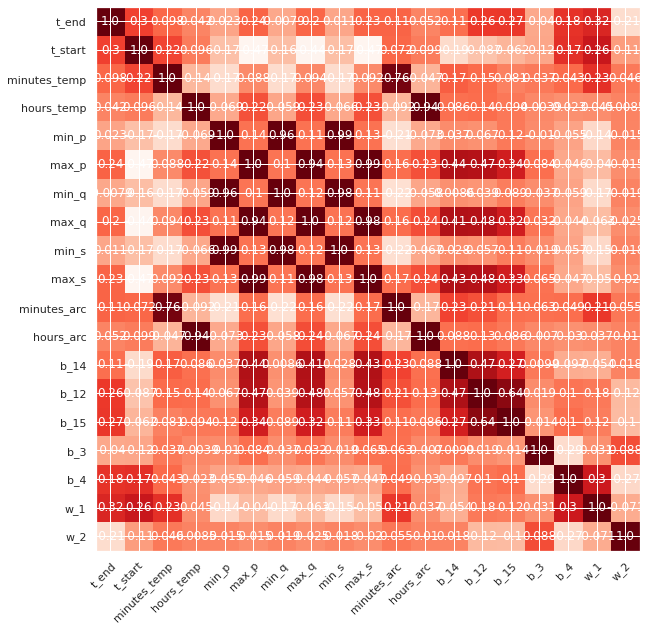

In [ ]:
corr_heatmap_data = full_pivot_merge_cor.corr()

fig, ax = plt.subplots(figsize=(10,10))
ax.set_xticks(np.arange(len(corr_heatmap_data.index)))
ax.set_yticks(np.arange(len(corr_heatmap_data.index)))

ax.set_xticklabels(corr_heatmap_data.index)
ax.set_yticklabels(corr_heatmap_data.index)

plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
         rotation_mode="anchor")

data = corr_heatmap_data.values

for i in range(len(corr_heatmap_data.index)):
    for j in range(len(corr_heatmap_data.index)):
        text = ax.text(j, i, '{:.2}'.format(data[i, j]),
                       ha="center", va="center", color="w")
        
im = ax.imshow(corr_heatmap_data.corr(), cmap='Reds')

**Наблюдается мультиколлинеарность**, т.е сильная корреляция между некоторыми признаками. Для ее устранения необходимо убрать из двух сильно коррелирующих признаков один. Прежде чем убирать какой-либо признак, необходимо также оценить его значимость для целевого признака.

In [ ]:
round(full_pivot_merge_cor.corr()['t_end'].sort_values(ascending=False), 2)

t_end           1.00
w_1             0.32
t_start         0.30
b_15            0.27
b_12            0.26
max_p           0.24
max_s           0.23
max_q           0.20
b_4             0.18
b_14            0.11
minutes_arc     0.11
minutes_temp    0.10
hours_arc       0.05
hours_temp      0.04
min_p           0.02
min_s           0.01
min_q          -0.01
b_3            -0.04
w_2            -0.21
Name: t_end, dtype: float64

Группу признаков: **hours_arc, hours_temp, min_p, min_s, min_q, b_3 можно убрать**, так как их влияние на `t_end` не превышает 0.1

In [ ]:
full_pivot_merge_cor = full_pivot_merge_cor.drop(['hours_arc',
                                                  'hours_temp',
                                                  'min_p',
                                                  'min_s',
                                                  'min_q',
                                                  'b_3'], axis=1)

In [ ]:
name_col_full_pivot_merge_cor = full_pivot_merge_cor.columns
name_col_full_pivot_merge_cor

Index(['t_end', 't_start', 'minutes_temp', 'max_p', 'max_q', 'max_s',
       'minutes_arc', 'b_14', 'b_12', 'b_15', 'b_4', 'w_1', 'w_2'],
      dtype='object')

In [ ]:
for i in range(len(name_col_full_pivot_merge_cor)):
    print("         ", name_col_full_pivot_merge_cor[i])
    print("------------------------")
    print(full_pivot_merge_cor.corr()[name_col_full_pivot_merge_cor[i]].sort_values(ascending=False).head(3))
    print()
    

          t_end
------------------------
t_end      1.000000
w_1        0.317673
t_start    0.295814
Name: t_end, dtype: float64

          t_start
------------------------
t_start    1.000000
t_end      0.295814
w_1        0.264368
Name: t_start, dtype: float64

          minutes_temp
------------------------
minutes_temp    1.000000
minutes_arc     0.756418
w_1             0.234460
Name: minutes_temp, dtype: float64

          max_p
------------------------
max_p    1.000000
max_s    0.990901
max_q    0.940308
Name: max_p, dtype: float64

          max_q
------------------------
max_q    1.000000
max_s    0.976738
max_p    0.940308
Name: max_q, dtype: float64

          max_s
------------------------
max_s    1.000000
max_p    0.990901
max_q    0.976738
Name: max_s, dtype: float64

          minutes_arc
------------------------
minutes_arc     1.000000
minutes_temp    0.756418
b_14            0.229007
Name: minutes_arc, dtype: float64

          b_14
------------------------
b_14    

In [ ]:
round(full_pivot_merge_cor.corr()['t_end'].sort_values(ascending=False), 2)

t_end           1.00
w_1             0.32
t_start         0.30
b_15            0.27
b_12            0.26
max_p           0.24
max_s           0.23
max_q           0.20
b_4             0.18
b_14            0.11
minutes_arc     0.11
minutes_temp    0.10
w_2            -0.21
Name: t_end, dtype: float64

**Существует корреляция между:**

* `minutes_temp - minutes_arc`: удалим **`minutes_temp`**, так как `minutes_arc` оказывает большее влияние на `t_end`;
* `max_s - max_p - max_q`: удалим **`max_s - max_q`**, так как `max_p` оказывает большее влияние на `t_end`;
* `b_12 - b_14`, `b_12 - b_15`: удалим **`w_12`**, так как это разъединит два других признака, которые она замыкает на себя (`b_15`, `b_14`).

In [ ]:
full_pivot_merge_cor = full_pivot_merge_cor.drop(['minutes_temp',
                                                  'max_s',
                                                  'max_p',
                                                  'b_12'], axis=1)

In [ ]:
full_pivot_merge_cor

,t_end,t_start,max_q,minutes_arc,b_14,b_15,b_4,w_1,w_2
0,1613.0,1571.0,1.062669,26,150.0,154.0,43.0,60.059998,0.00000
1,1602.0,1581.0,0.892914,19,149.0,154.0,73.0,96.052315,0.00000
2,1599.0,1596.0,0.671494,25,152.0,153.0,34.0,91.160157,0.00000
3,1625.0,1601.0,0.754719,18,153.0,154.0,81.0,89.063515,0.00000
4,1602.0,1576.0,1.047776,22,151.0,152.0,78.0,89.238236,9.11456
...,...,...,...,...,...,...,...,...,...
2279,1591.0,1570.0,0.769281,20,129.0,223.0,0.0,89.150879,0.00000
2280,1591.0,1554.0,0.701201,23,129.0,226.0,63.0,114.179527,0.00000
2281,1589.0,1571.0,0.701218,12,124.0,226.0,85.0,94.086723,9.04800
2282,1594.0,1591.0,0.832519,22,129.0,207.0,0.0,118.110717,0.00000


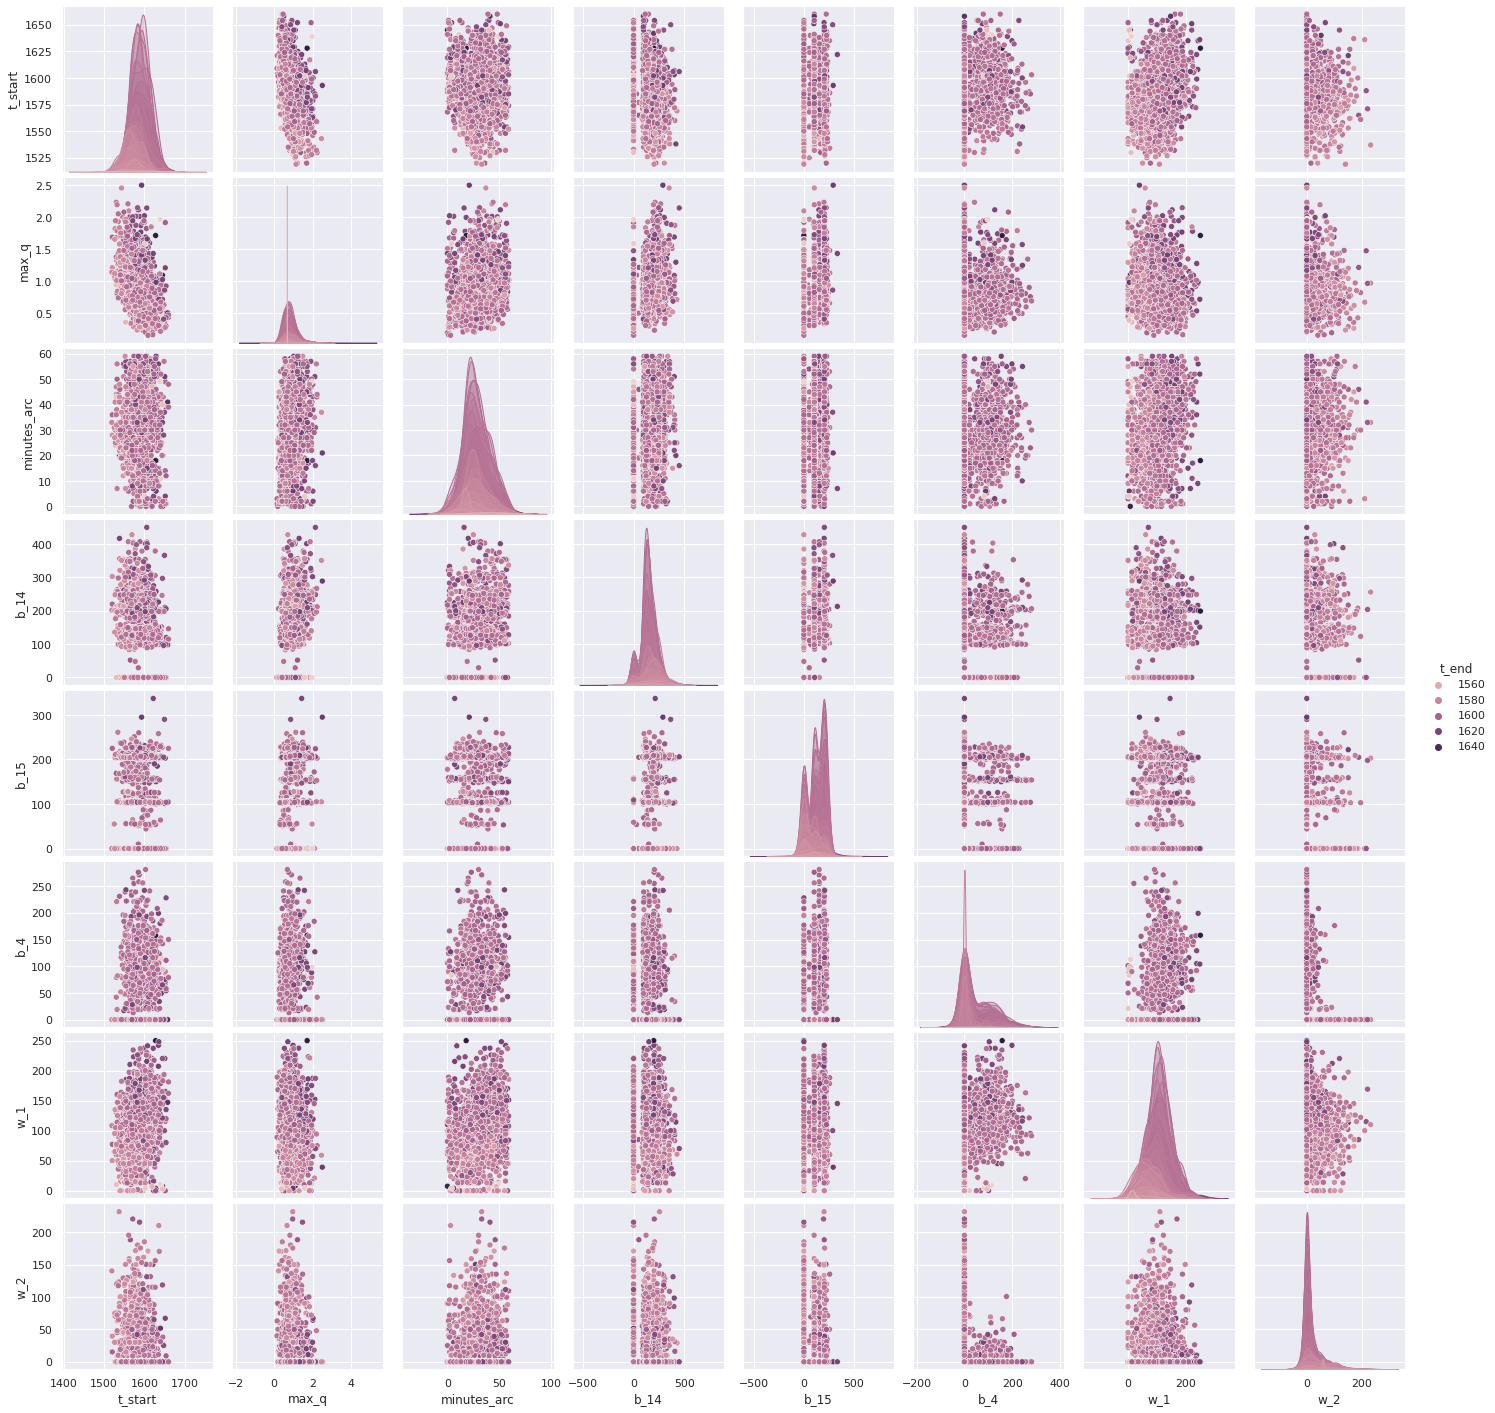

In [ ]:
# изучение корреляции в данных
sns.pairplot(full_pivot_merge_cor, hue="t_end");

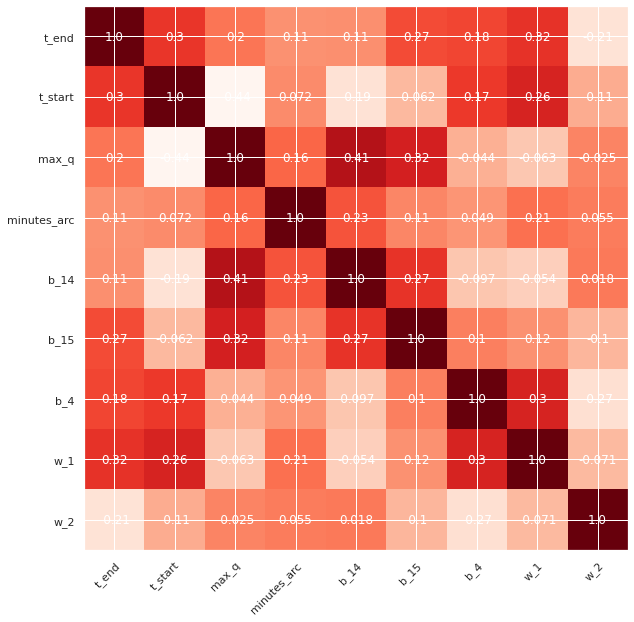

In [ ]:
corr_heatmap_data = full_pivot_merge_cor.corr()

fig, ax = plt.subplots(figsize=(10,10))
ax.set_xticks(np.arange(len(corr_heatmap_data.index)))
ax.set_yticks(np.arange(len(corr_heatmap_data.index)))

ax.set_xticklabels(corr_heatmap_data.index)
ax.set_yticklabels(corr_heatmap_data.index)

plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
         rotation_mode="anchor")

data = corr_heatmap_data.values

for i in range(len(corr_heatmap_data.index)):
    for j in range(len(corr_heatmap_data.index)):
        text = ax.text(j, i, '{:.2}'.format(data[i, j]),
                       ha="center", va="center", color="w")
        
im = ax.imshow(corr_heatmap_data.corr(), cmap='Reds')

Как видно на графике парных отношений в наборе данных, а также на тепловой карте от мультиколлинеарности удалось избавиться.

In [ ]:
features = full_pivot_merge_cor.drop(['t_end'], axis=1)
target = full_pivot_merge_cor['t_end']

In [ ]:
features

,t_start,max_q,minutes_arc,b_14,b_15,b_4,w_1,w_2
0,1571.0,1.062669,26,150.0,154.0,43.0,60.059998,0.00000
1,1581.0,0.892914,19,149.0,154.0,73.0,96.052315,0.00000
2,1596.0,0.671494,25,152.0,153.0,34.0,91.160157,0.00000
3,1601.0,0.754719,18,153.0,154.0,81.0,89.063515,0.00000
4,1576.0,1.047776,22,151.0,152.0,78.0,89.238236,9.11456
...,...,...,...,...,...,...,...,...
2279,1570.0,0.769281,20,129.0,223.0,0.0,89.150879,0.00000
2280,1554.0,0.701201,23,129.0,226.0,63.0,114.179527,0.00000
2281,1571.0,0.701218,12,124.0,226.0,85.0,94.086723,9.04800
2282,1591.0,0.832519,22,129.0,207.0,0.0,118.110717,0.00000


In [ ]:
name_features = features.columns
list(name_features)

['t_start', 'max_q', 'minutes_arc', 'b_14', 'b_15', 'b_4', 'w_1', 'w_2']

In [ ]:
# масштабирование признаков
numeric = ['t_start', 'max_q', 'minutes_arc', 'b_14', 'b_15', 'b_4', 'w_1', 'w_2']

scaler = StandardScaler()
scaler.fit(features[numeric])
features[numeric] = scaler.transform(features[numeric])

### Вывод

**В результате подготовки данных:**

1. Устранена мультиколлинеарность.
2. Перед моделированием применено масштабирование.

## Обучение модели

In [ ]:
features

,t_start,max_q,minutes_arc,b_14,b_15,b_4,w_1,w_2
0,-0.685307,0.583821,-0.186928,-0.047853,0.402844,0.099008,-0.978280,-0.527770
1,-0.263011,0.091977,-0.756404,-0.060234,0.402844,0.609737,-0.143960,-0.527770
2,0.370434,-0.549556,-0.268282,-0.023092,0.390985,-0.054211,-0.257363,-0.527770
3,0.581582,-0.308424,-0.837758,-0.010711,0.402844,0.745931,-0.305964,-0.527770
4,-0.474159,0.540669,-0.512343,-0.035473,0.379126,0.694858,-0.301914,-0.253031
...,...,...,...,...,...,...,...,...
2279,-0.727537,-0.266231,-0.675050,-0.307848,1.221130,-0.633037,-0.303939,-0.527770
2280,-1.403212,-0.463483,-0.430989,-0.307848,1.256707,0.439494,0.276238,-0.527770
2281,-0.685307,-0.463436,-1.325879,-0.369752,1.256707,0.814029,-0.189523,-0.255037
2282,0.159286,-0.083010,-0.512343,-0.307848,1.031383,-0.633037,0.367365,-0.527770


In [ ]:
target

0       1613.0
1       1602.0
2       1599.0
3       1625.0
4       1602.0
         ...  
2279    1591.0
2280    1591.0
2281    1589.0
2282    1594.0
2283    1603.0
Name: t_end, Length: 2284, dtype: float64

In [ ]:
features_train, features_test, target_train, target_test = train_test_split(
                                                            features, 
                                                            target, 
                                                            test_size=0.20, 
                                                            random_state=12092022)

#### LinearRegression

In [ ]:
%%time

model = LinearRegression()
parametrs = { 'fit_intercept':[True,False], 'normalize':[True,False], 'copy_X':[True, False] }
search = GridSearchCV(model, parametrs, cv=5, scoring='neg_mean_absolute_error')
search.fit(features_train, target_train)
best_model_LinearRegression = search.best_estimator_
best_score_model_LinearRegression = abs(round(search.best_score_, 3))
print('# # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # #')
print('Модель:', best_model_LinearRegression)
print('Параметры лучшей модели:', search.best_params_)
print('best_score:', best_score_model_LinearRegression)

# # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # #
Модель: LinearRegression(normalize=True)
Параметры лучшей модели: {'copy_X': True, 'fit_intercept': True, 'normalize': True}
best_score: 6.993
CPU times: user 239 ms, sys: 193 ms, total: 433 ms
Wall time: 222 ms


#### CatBoostRegressor

In [ ]:
%%time

model = CatBoostRegressor()
parametrs = { 'depth': range (1, 9, 2),
              'n_estimators': range (1, 9, 2) }
search = GridSearchCV(model, parametrs, cv=5, scoring='neg_mean_absolute_error')
search.fit(features_train, target_train)
best_model_CatBoostRegressor = search.best_estimator_
best_score_model_CatBoostRegressor = abs(round(search.best_score_, 3))
print('# # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # ')
print('Модель:', best_model_CatBoostRegressor)
print('Параметры лучшей модели:', search.best_params_)
print('best_score:', best_score_model_CatBoostRegressor)

Learning rate set to 0.5
0:	learn: 10.8784994	total: 492us	remaining: 0us
Learning rate set to 0.5
0:	learn: 11.0185176	total: 478us	remaining: 0us
Learning rate set to 0.5
0:	learn: 10.8835146	total: 469us	remaining: 0us
Learning rate set to 0.5
0:	learn: 10.9607292	total: 411us	remaining: 0us
Learning rate set to 0.5
0:	learn: 11.1383205	total: 515us	remaining: 0us
Learning rate set to 0.5
0:	learn: 10.8784994	total: 383us	remaining: 767us
1:	learn: 10.6319764	total: 674us	remaining: 337us
2:	learn: 10.3567148	total: 979us	remaining: 0us
Learning rate set to 0.5
0:	learn: 11.0185176	total: 356us	remaining: 713us
1:	learn: 10.7040104	total: 655us	remaining: 327us
2:	learn: 10.4661701	total: 1.15ms	remaining: 0us
Learning rate set to 0.5
0:	learn: 10.8835146	total: 436us	remaining: 873us
1:	learn: 10.5619255	total: 1.21ms	remaining: 603us
2:	learn: 10.3307416	total: 2.05ms	remaining: 0us
Learning rate set to 0.5
0:	learn: 10.9607292	total: 390us	remaining: 780us
1:	learn: 10.7138104	to

#### RandomForestRegressor

In [ ]:
%%time

model = RandomForestRegressor()
parametrs = {'bootstrap': [True, False],
               'max_depth': [10, 20, 30, None],
               'max_features': ['auto', 'sqrt'],
               'min_samples_leaf': [1, 2, 4],
               'min_samples_split': [2, 5, 10],
               'n_estimators': [13, 18, 23, 34, 45, 56, 78]}
search = RandomizedSearchCV(model, parametrs, cv=5, scoring='neg_mean_absolute_error')
search.fit(features_train, target_train)
best_model_RandomForestRegressor = search.best_estimator_
best_score_model_RandomForestRegressor = abs(round(search.best_score_, 3))
print('# # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # #')
print('Модель:', best_model_RandomForestRegressor)
print('Параметры лучшей модели:', search.best_params_)
print('best_score:', best_score_model_RandomForestRegressor)

# # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # #
Модель: RandomForestRegressor(min_samples_leaf=4, min_samples_split=5, n_estimators=78)
Параметры лучшей модели: {'n_estimators': 78, 'min_samples_split': 5, 'min_samples_leaf': 4, 'max_features': 'auto', 'max_depth': None, 'bootstrap': True}
best_score: 6.931
CPU times: user 17.8 s, sys: 11.9 ms, total: 17.8 s
Wall time: 17.9 s


#### XGBRegressor

In [ ]:
%%time

model = XGBRegressor()
parametrs = {'nthread':[4],
             'objective':['reg:linear'],
             'learning_rate': [.03, 0.05, .07],
             'max_depth': [5, 6, 7],
             'min_child_weight': [4],
             'silent': [1],
             'subsample': [0.7],
             'colsample_bytree': [0.7],
             'n_estimators': [200]}
search = GridSearchCV(model, parametrs, cv=3, scoring='neg_mean_absolute_error')
search.fit(features_train, target_train)
best_model_XGBRegressor = search.best_estimator_
best_score_model_XGBRegressor = abs(round(search.best_score_, 3))
print('# # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # #')
print('Модель:', best_model_XGBRegressor)
print('Параметры лучшей модели:', search.best_params_)
print('best_score:', best_score_model_XGBRegressor)

# # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # #
Модель: XGBRegressor(colsample_bytree=0.7, learning_rate=0.05, max_depth=5,
             min_child_weight=4, n_estimators=200, nthread=4, silent=1,
             subsample=0.7)
Параметры лучшей модели: {'colsample_bytree': 0.7, 'learning_rate': 0.05, 'max_depth': 5, 'min_child_weight': 4, 'n_estimators': 200, 'nthread': 4, 'objective': 'reg:linear', 'silent': 1, 'subsample': 0.7}
best_score: 6.904
CPU times: user 10.7 s, sys: 2.21 s, total: 13 s
Wall time: 9.3 s


#### Выбор лучшей модели

In [ ]:
list_model = [best_model_LinearRegression,
              best_model_CatBoostRegressor,
              best_model_RandomForestRegressor,
              best_model_XGBRegressor]

In [ ]:
list_model

[LinearRegression(normalize=True),
 RandomForestRegressor(min_samples_leaf=4, min_samples_split=5, n_estimators=78),
 XGBRegressor(colsample_bytree=0.7, learning_rate=0.05, max_depth=5,
              min_child_weight=4, n_estimators=200, nthread=4, silent=1,
              subsample=0.7)]

In [ ]:
list_score = [best_score_model_LinearRegression,
              best_score_model_CatBoostRegressor,
              best_score_model_RandomForestRegressor,
              best_score_model_XGBRegressor]

In [ ]:
intermediate_dictionary = {'Model':list_model, 'MAE':list_score}

In [ ]:
rating_model = pd.DataFrame(intermediate_dictionary)

In [ ]:
rating = rating_model.sort_values(by='MAE')
rating

,Model,MAE
3,"XGBRegressor(colsample_bytree=0.7, learning_ra...",6.904
2,"(DecisionTreeRegressor(max_features='auto', mi...",6.931
0,LinearRegression(normalize=True),6.993
1,<catboost.core.CatBoostRegressor object at 0x7...,7.017


### Вывод

**В результате обучения и подбора лучших параметров моделей, установлено:**

1. Лучшая модель: XGBRegressor.
2. Параметры лучшей модели: {'colsample_bytree': 0.7, 'learning_rate': 0.05, 'max_depth': 5, 'min_child_weight': 4, 'n_estimators': 200, 'nthread': 4, 'objective': 'reg:linear', 'silent': 1, 'subsample': 0.7}.
3. Качество модели (MAE): 6.904.


## Проверка качества модели на тестовой выборке

In [ ]:
mod = best_model_XGBRegressor

In [ ]:
mod.fit(features_train, target_train)
test_predictions = mod.predict(features_test)
result = mean_absolute_error(target_test, test_predictions)
print()
print("Лучшая модель:", mod)
print("MAE лучшей модели на тестовой выборке:", abs(round(result, 1)))


Лучшая модель: XGBRegressor(colsample_bytree=0.7, learning_rate=0.05, max_depth=5,
             min_child_weight=4, n_estimators=200, nthread=4, silent=1,
             subsample=0.7)
MAE лучшей модели на тестовой выборке: 6.7


### Оценка важности факторов

In [ ]:
import seaborn as sns
def chart_feature_imp(model):
    feature_imp = pd.Series(model.feature_importances_, index=features_test.columns).sort_values(ascending=False)

    ax = sns.barplot(x=feature_imp, y=feature_imp.index)
    _ = ax.set(xlabel='Оценка важности признаков', ylabel='Признаки')
    _ = ax.set_title('Визуализация важности признаков')


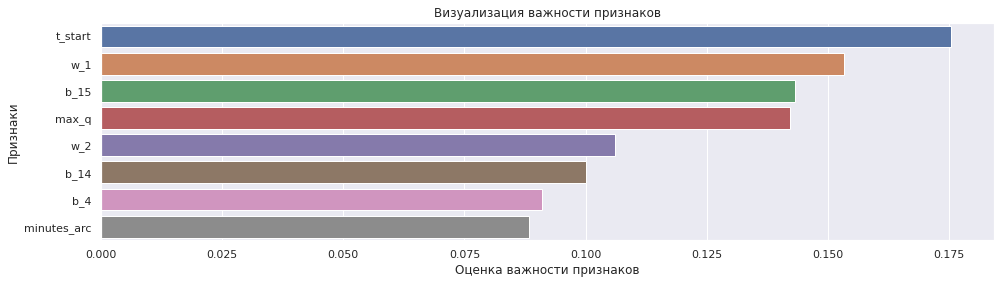

In [ ]:
chart_feature_imp(mod)

## Общий вывод

**I. В результате предварительного анализа данных, установлено:**

1. В столбце "Время замера" таблицы `data_temp` (результаты измерения температуры) тип object, а должен быть datetime.
2. В столбце "Начало нагрева дугой" таблицы `data_arc` (данные об электродах) тип object, а должен быть datetime.
3. В столбце "Конец нагрева дугой" таблицы `data_arc` (данные об электродах) тип object, а должен быть datetime.
4. Во всех столбцах таблиц `data_wire_time` (данные о проволочных материалах (время)), `data_bulk_time` (данные о подаче сыпучих материалов (время)) тип object, а должен быть datetime.

**II. В результате анализа описательной статистики и пропусков, установлено:**

1. В таблице `data_wire` (данные о проволочных материалах (объём)) многие столбцы имеют пропуски от 0.84% до 99.97%.
2. В таблице `data_temp` (результаты измерения температуры) в столбце "Температура" имеется 18.24% пропусков.
3. В таблице `data_bulk` (данные о подаче сыпучих материалов (объём)) многие столбцы имеют пропуски от 10.32% до 99.97%.
4. В таблице `data_arc` (данные об электродах) в столбце "Реактивная мощность" обнаружено аномальное минимальное значение: - 715.504924.

**III. На основе предварительного анализа данных, для дальнейшего исследования установлены следующие положения:**

1. Поскольку случайные величины всегда порождаются бесконечным количеством причин и чаще всего ни одна из них не имеет дисперсии, сравнимой с дисперсией самой случайной величины, то большинство встречающихся **в практике** случайных величин подчинено **нормальному закону распределения**. [Нормальное распределение — **наиболее распространенное в природе распределение** непрерывных величин. Математическим обоснованием этого факта служит центральная предельная теорема](http://datascientist.one/central-limit-theorem/).

2. **Выбросом** считается наблюдение, которое лежит аномально далеко от остальных из серии параллельных наблюдений. Т.е. выбросы – это значения количественного признака, располагающиеся на краях интервала допустимых значений. Таким образом, при определении выбросов будем опираться на значения 0-перцентиля и 100-перцентиля, а также рекомендации бизнеса и особенности технологического процесса. **Удалению будут подлежать супервыбросы (относительно далеко отстающие единичные значения или небольшие группы  относительно основного распределения).**

**IV. Таким образом, для дальнейшего моделирования необходимо вынести следующие тезисы:**

1. так как при моделировании будет решаться задача регрессе, то для нее лучше вообще убрать столбцы с временем, так как модель может начать пытаться найти функциональную связь в датах и времени;
2. исходя из технологического процесса пропуски в таблицах `data_wire` и `data_bulk` обусловлены тем, что на каких-то итерациях процесса просто не добавляли либо проволочных материалов, либо сыпучих материалов, поэтому целесообразно их заполнить нулями;
3. в таблице `data_temp` в столбце "Температура" находится целевой признак и, поэтому мы будем вынуждены удалить строки с пропусками, так же стоит поступить с  супервыбросами, обнаруженными:
    - в таблице `data_arc` столбец «Реактивная мощность» при этом для моделирования возьмём диапазон значений [0, 3.5];
    - в таблице `data_temp` столбец «Температура», при этом для моделирования возьмём диапазон значений [1400, 1705] (целевой признак);
    - в таблице `data_wire` столбец «Wire 1», при этом для моделирования возьмём диапазон значений [0, 260];
    - в таблице `data_wire` столбец «Wire 2», при этом для моделирования возьмём диапазон значений [0, 260];
    - в таблице `data_bulk` столбец «Bulk 12», при этом для моделирования возьмём диапазон значений [0, 1000];
    - в таблице `data_bulk` столбец «Bulk 15», при этом для моделирования возьмём диапазон значений [0, 400].

**V. В результате подготовки данных:**

1. Устранена мультиколлинеарность.
2. Перед моделированием применено масштабирование.

**VI. В результате обучения и подбора лучших параметров моделей, установлено:**

1. Лучшая модель: XGBRegressor.
2. Параметры лучшей модели: {'colsample_bytree': 0.7, 'learning_rate': 0.05, 'max_depth': 5, 'min_child_weight': 4, 'n_estimators': 200, 'nthread': 4, 'objective': 'reg:linear', 'silent': 1, 'subsample': 0.7}.
3. Качество модели (MAE): 6.904.

**VII. В результате проверки качества модели на тестовой выборке:**

1.  MAE лучшей модели на тестовой выборке: 6.7.
2.  Значение MAE удовлетворяет условию бизнеса: MAE ≤ 6.8.
3.  В тройку самых значимых факторов входит:
  * начальная температура;
  * объем проволочных материалов;
  * объем сыпучих материалов.